Elaboration of data output from SQL database

In [76]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [77]:
# Define the parameter
user_name = 'UserD'

# Importing from esm database.db
conn = sqlite3.connect('database.db')

# Use parameterized queries
query_cost_op_tot = "SELECT * FROM cost_op_tot WHERE s_names=?"
cost_op_tot = pd.read_sql_query(query_cost_op_tot, conn, params=(user_name,))

query_cost_period = "SELECT * FROM cost_period"
cost_period = pd.read_sql_query(query_cost_period, conn)

query_active_techs = "SELECT * FROM active_techs WHERE s_names=?"
active_techs = pd.read_sql_query(query_active_techs, conn, params=(user_name,))

query_cost_cap = "SELECT * FROM cost_cap"
cost_cap = pd.read_sql_query(query_cost_cap, conn)

query_cap_tot = "SELECT * FROM cap_tot WHERE s_names=?"
cap_tot = pd.read_sql_query(query_cap_tot, conn, params=(user_name,))

query_cost_inv = "SELECT * FROM cost_inv WHERE s_names=?"
cost_inv = pd.read_sql_query(query_cost_inv, conn, params=(user_name,))

query_new_units = "SELECT * FROM new_units WHERE s_names=?"
new_units = pd.read_sql_query(query_new_units, conn, params=(user_name,))

# For scalar values
query_disc_frac = "SELECT * FROM disc_frac WHERE s_names=?"
disc_frac_pd = pd.read_sql_query(query_disc_frac, conn, params=(user_name,))
disc_frac = disc_frac_pd['values'].iloc[0]

query_insulation = "SELECT * FROM insulation WHERE s_names=?"
insulation_pd = pd.read_sql_query(query_insulation, conn, params=(user_name,))
insulation = insulation_pd['values'].iloc[0]

query_TI_cost = "SELECT * FROM TI_cost WHERE s_names=?"
TI_cost_pd = pd.read_sql_query(query_TI_cost, conn, params=(user_name,))
TI_cost = TI_cost_pd['values'].iloc[0]

conn.close()

In [78]:
activity_costs=sum(cost_op_tot['values'])
periodic_costs=sum((cost_period['values']+(cost_cap['values']*cap_tot['values']))*active_techs['values'])
bill_one_year=activity_costs+periodic_costs
discount=sum(disc_frac ** x for x in range(1, 11))
operation_costs_discounted=bill_one_year*discount
investment_costs=sum(cost_inv['values']*new_units['values'])
NPC=operation_costs_discounted+investment_costs

print('The NPC is over 10 years is: ', round(NPC,2),'€')
print('For each year the operative expenses are:', round(bill_one_year,2), '€')
print('The initial investment cost is:', round(investment_costs,2),'€')


The NPC is over 10 years is:  29537.49 €
For each year the operative expenses are: 1904.32 €
The initial investment cost is: 13700.0 €


In [79]:
investment_cost_breakdown=pd.DataFrame()
investment_cost_breakdown['t_names']=cost_inv['t_names']
investment_cost_breakdown['values']=cost_inv['values']*new_units['values']
print('Technology expansion investment:\n', investment_cost_breakdown[investment_cost_breakdown['values']!=0])

Technology expansion investment:
             t_names  values
0            PV sys  2500.0
1  National Grid EE   500.0
4                HP  1700.0
7         Radiators  8500.0
9   Induction stove   500.0


In [80]:
# Importing from esm database.db
conn = sqlite3.connect('database.db')

query_Y = "SELECT * FROM Y WHERE s_names=?"  
Y = pd.read_sql_query(query_Y, conn, params=(user_name,))
query_Q = "SELECT * FROM Q WHERE s_names=?"
Q = pd.read_sql_query(query_Q, conn, params=(user_name,))
query_X = "SELECT * FROM X WHERE s_names=?"
X = pd.read_sql_query(query_X, conn, params=(user_name,))
query_Xt = "SELECT * FROM X_t WHERE s_names=?"
Xt = pd.read_sql_query(query_Xt, conn, params=(user_name,))
query_DPT = "SELECT * FROM days_per_type"
DPT = pd.read_sql_query(query_DPT, conn)
query_SOC = "SELECT * FROM SOC WHERE s_names=?"
SOC = pd.read_sql_query(query_SOC, conn, params=(user_name,))
conn.close()

In [81]:
seasons = ['wi', 'mc', 'mw', 'su']
season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

In [82]:
#Isolate peak hour
peak_Y= Y[Y['th_names'] == 'peak']
Y=Y[Y['th_names'] != 'peak']
peak_Q= Q[Q['th_names'] == 'peak']
Q=Q[Q['th_names'] != 'peak']
peak_X=X[X['th_names'] == 'peak']
X=X[X['th_names'] != 'peak']
peak_Xt=Xt[Xt['th_names'] == 'peak']
Xt=Xt[Xt['th_names'] != 'peak']
SOC=SOC[SOC['th_names'] != 'peak']
DPT=DPT[DPT['days_names'] != 'peak']

In [83]:
#Temporal features
for db in [Y,Q,X,Xt,SOC]:
    db.index=range(len(db))
    db.loc[:,'season']=db['th_names'].str[4:6]
    db['hour'] = db['th_names'].str[1:3].astype(int)
    db['day'] = db['th_names'].str[-2:].astype(int)
    db['time'] = (db['day'] - 1) * 24 + db['hour']

Costs and consumption

In [84]:
#EE consumption
cost_EE_period=cost_period.loc[cost_period['t_names']=='National Grid EE']['values'].values[0]+cost_cap.loc[cost_cap['t_names']=='National Grid EE']['values'].values[0]*cap_tot.loc[cap_tot['t_names']=='National Grid EE']['values'].values[0]
cost_EE=cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0]+cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0]+cost_EE_period
print('Yearly variable cost for electricity import:',round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0],2),'€')
print('Yearly fixed cost for electricity import:',round(cost_EE_period,2),'€')
print('Yearly income for electricity export:',round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0],2),'€')
print('Yearly net cost for electricity',round(cost_EE,2),'€')

Yearly variable cost for electricity import: 1669.19 €
Yearly fixed cost for electricity import: 200.0 €
Yearly income for electricity export: -39.87 €
Yearly net cost for electricity 1829.32 €


In [85]:
#NG consumption
cost_NG_period=cost_period.loc[cost_period['t_names']=='Gas National Grid']['values'].values[0]+cost_cap.loc[cost_cap['t_names']=='Gas National Grid']['values'].values[0]*cap_tot.loc[cap_tot['t_names']=='Gas National Grid']['values'].values[0]
cost_NG=cost_op_tot.loc[cost_op_tot['a_names']=='Natural Gas supply grid']['values'].values[0]+cost_EE_period
print('Yearly variable cost for natural gas import:',round(cost_op_tot.loc[cost_op_tot['a_names']=='Natural Gas supply grid']['values'].values[0],2),'€')
print('Yearly fixed cost for natural gas import:',round(cost_NG_period,2),'€')
print('Yearly total cost for natural gas',round(cost_NG,2),'€')

Yearly variable cost for natural gas import: 0.0 €
Yearly fixed cost for natural gas import: 170.0 €
Yearly total cost for natural gas 200.0 €


In [86]:
#Function to aggregate hourly data into daily data
def compute_daily(df):
    #Group by day and season
    df = df.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
    #Fix the order
    season_order = ['wi', 'mc', 'mw', 'su']
    df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)
    df_sorted = df.sort_values(by=['season', 'day'])
    df_sorted.index = range(len(df_sorted))

    return df_sorted

In [87]:
#Yearly electricity consumption, production and supply
Q_EE=Q[Q['n_names']=='EE']
Q_EE_daily = compute_daily(Q_EE)
Q_EE_daily['consumption'] = Q_EE_daily['consumption']*DPT['values']
Q_EE_tot=sum(Q_EE_daily['consumption'])
print('Yearly consumption of electricity:',round(Q_EE_tot,2),'kWh')
X_EE_daily = compute_daily(X[X['a_names']=='National Grid import'])
X_EE_daily['consumption'] = X_EE_daily['consumption']*DPT['values']
print('Yearly import of electricity from National Grid:',round(sum(X_EE_daily['consumption']),2),'kWh')
print('Yearly auto-consumption',round(sum(Q_EE_daily['consumption'])-sum(X_EE_daily['consumption']),2),'kWh')
PV_prod=X[X['a_names']=='PV']
X_PV_daily = compute_daily(PV_prod)
X_PV_daily['consumption'] = X_PV_daily['consumption']*DPT['values']
print('Yearly PV production:',round(sum(X_PV_daily['consumption']),2),'kWh')
PV_sell=X[X['a_names']=='National Grid export']
X_sell_daily = compute_daily(PV_sell)
X_sell_daily['consumption'] = X_sell_daily['consumption']*DPT['values']
print('Yearly export of electricity to National Grid:',round(sum(X_sell_daily['consumption']),2),'kWh')


Yearly consumption of electricity: 10436.54 kWh
Yearly import of electricity from National Grid: 8345.96 kWh
Yearly auto-consumption 2090.58 kWh
Yearly PV production: 2946.19 kWh
Yearly export of electricity to National Grid: 855.6 kWh


GRAPHS

Electricity: use

In [88]:
EE_base=Y[Y['n_names']=='EE']
EE_HP_thermal=Xt[Xt['t_names']=='HP']
EE_HP_wi_mc=EE_HP_thermal.loc[EE_HP_thermal['season'].isin(['wi', 'mc']), 'values'] /3.7
EE_HP_mw_su=EE_HP_thermal.loc[EE_HP_thermal['season'].isin(['su', 'mw']), 'values'] /5
EE_HP=EE_HP_thermal.copy()
EE_HP['values']=pd.concat([EE_HP_wi_mc,EE_HP_mw_su])
EE_AC=X[X['a_names']=='AC cooling']
EE_AC['values']=EE_AC['values']/6
EE_HP_cool=X[X['a_names']=='HP cooling']
EE_HP_cool['values']=EE_HP_cool['values']/4
EE_cook=X[X['a_names']=='Induction stove cooking']
EE_cook['values']=EE_cook['values']*1.25
EE_base.index=EE_HP.index=EE_AC.index=EE_HP_cool.index=EE_cook.index=range(len(EE_base))

/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_53992/2190863939.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EE_AC['values']=EE_AC['values']/6
/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_53992/2190863939.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EE_HP_cool['values']=EE_HP_cool['values']/4
/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_53992/2190863939.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

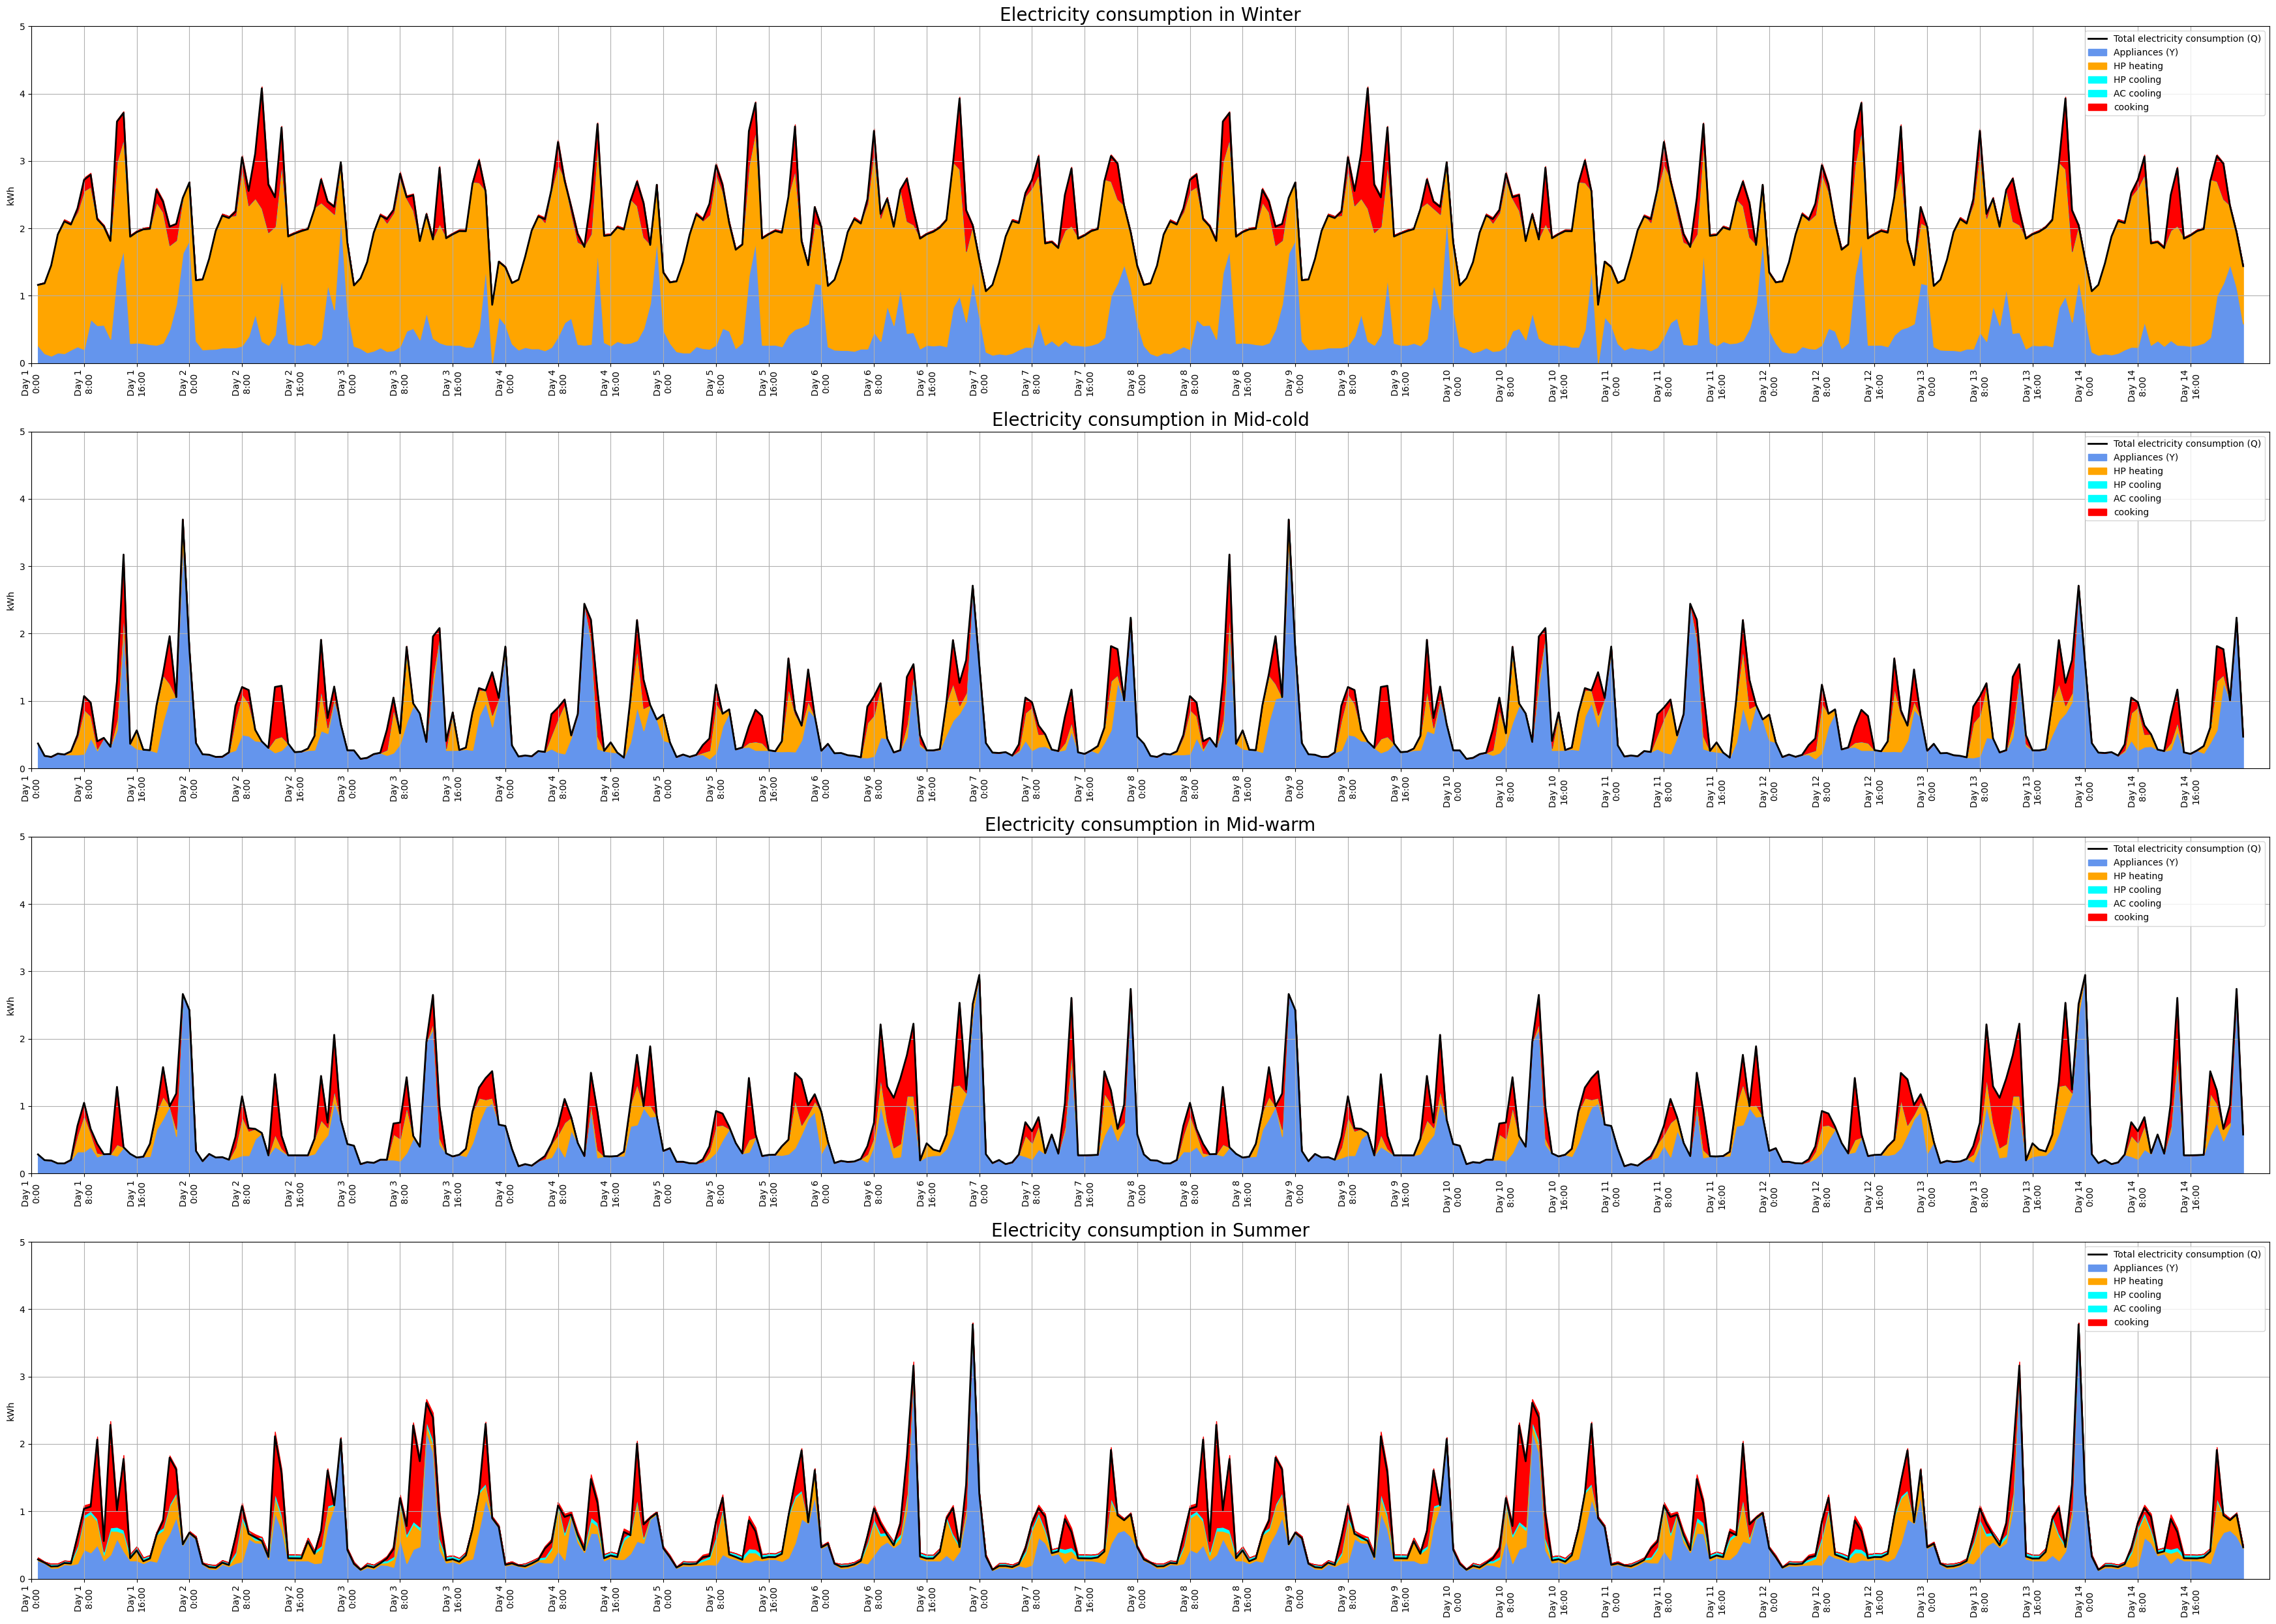

In [89]:
#Electricity consumption
plt.figure(figsize=(35, 25))
Time=range(1,337)
Time_ind=pd.Index(range(1, 337))

ore_totali = 336

# Impostiamo le etichette per le ore del giorno (0-23) ripetute per 10 giorni
day_h = np.tile(np.arange(24), 14)  # Ripeti le ore da 0 a 23 per 10 volte
# Creiamo un array per i giorni (Day 1, Day 2, ... Day 14)
day_names = np.repeat([f'Day {i+1}' for i in range(14)], 24)
# Uniamo i giorni e le ore per creare le etichette delle x
x_labels = [f'{day}\n{hour}:00' for day,hour in zip(day_names,day_h)]

# Impostiamo le etichette sull'asse delle x ogni 6 ore

for i, season in enumerate(seasons, 1):
    Q_season = Q[(Q['season'] == season) & (Q['n_names'] == 'EE')]['values']
    EE_base_season = EE_base[EE_base['season'] == season]['values']
    EE_HP_season = EE_HP[EE_HP['season'] == season]['values']
    EE_cook_season = EE_cook[EE_cook['season'] == season]['values']
    EE_HP_cool_season = EE_HP_cool[EE_HP_cool['season'] == season]['values']
    EE_AC_season = EE_AC[EE_AC['season'] == season]['values']

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_season, color='black', linewidth=2, label='Total electricity consumption (Q)')
    plt.fill_between(Time,0,EE_base_season, color='cornflowerblue', label='Appliances (Y)')
    plt.fill_between(Time,EE_base_season,EE_base_season+EE_HP_season, color='orange', label='HP heating')
    plt.fill_between(Time,EE_base_season+EE_HP_season,EE_base_season+EE_HP_season+EE_HP_cool_season, color='cyan', label='HP cooling')
    plt.fill_between(Time,EE_base_season+EE_HP_season+EE_HP_cool_season,EE_base_season+EE_HP_season+EE_HP_cool_season+EE_AC_season, color='cyan', label='AC cooling')
    plt.fill_between(Time,EE_base_season+EE_HP_season+EE_HP_cool_season+EE_AC_season,EE_base_season+EE_HP_season+EE_HP_cool_season+EE_AC_season+EE_cook_season, color='red', label='cooking')
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('kWh')
    plt.ylim(0,5)
    plt.xlim(0,340)
    plt.title(f'Electricity consumption in {season_names[season]}',fontsize=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Electricity: supply

In [90]:
Battery=X[X['a_names']=='Storing EE']
PV_prod.index = Q_EE.index = PV_sell.index =Battery.index = range(len(PV_prod))

Batt_charge=Battery.copy()
Batt_charge['values'] = Batt_charge['values'].apply(lambda x: 0 if x > 0 else x)

PV_consump=PV_prod.copy()
PV_consump['values']=PV_prod['values'].to_numpy()-PV_sell['values'].to_numpy()+Battery['values'].to_numpy()
PV_consump['values'] = PV_consump['values'].where(PV_prod['values']>0, 0) 
PV_consump['values'] = PV_prod['values'].where((PV_prod['values']<Q_EE['values']) & (Battery['values']>=0), PV_consump['values'])

Batt_discharge=Battery.copy()
Batt_discharge['values'] = Batt_discharge['values'].to_numpy()-PV_sell['values'].to_numpy()
Batt_discharge['values'] = Batt_discharge['values'].apply(lambda x: 0 if x < 0 else x)

EE_grid=X[X['a_names']=='National Grid import']

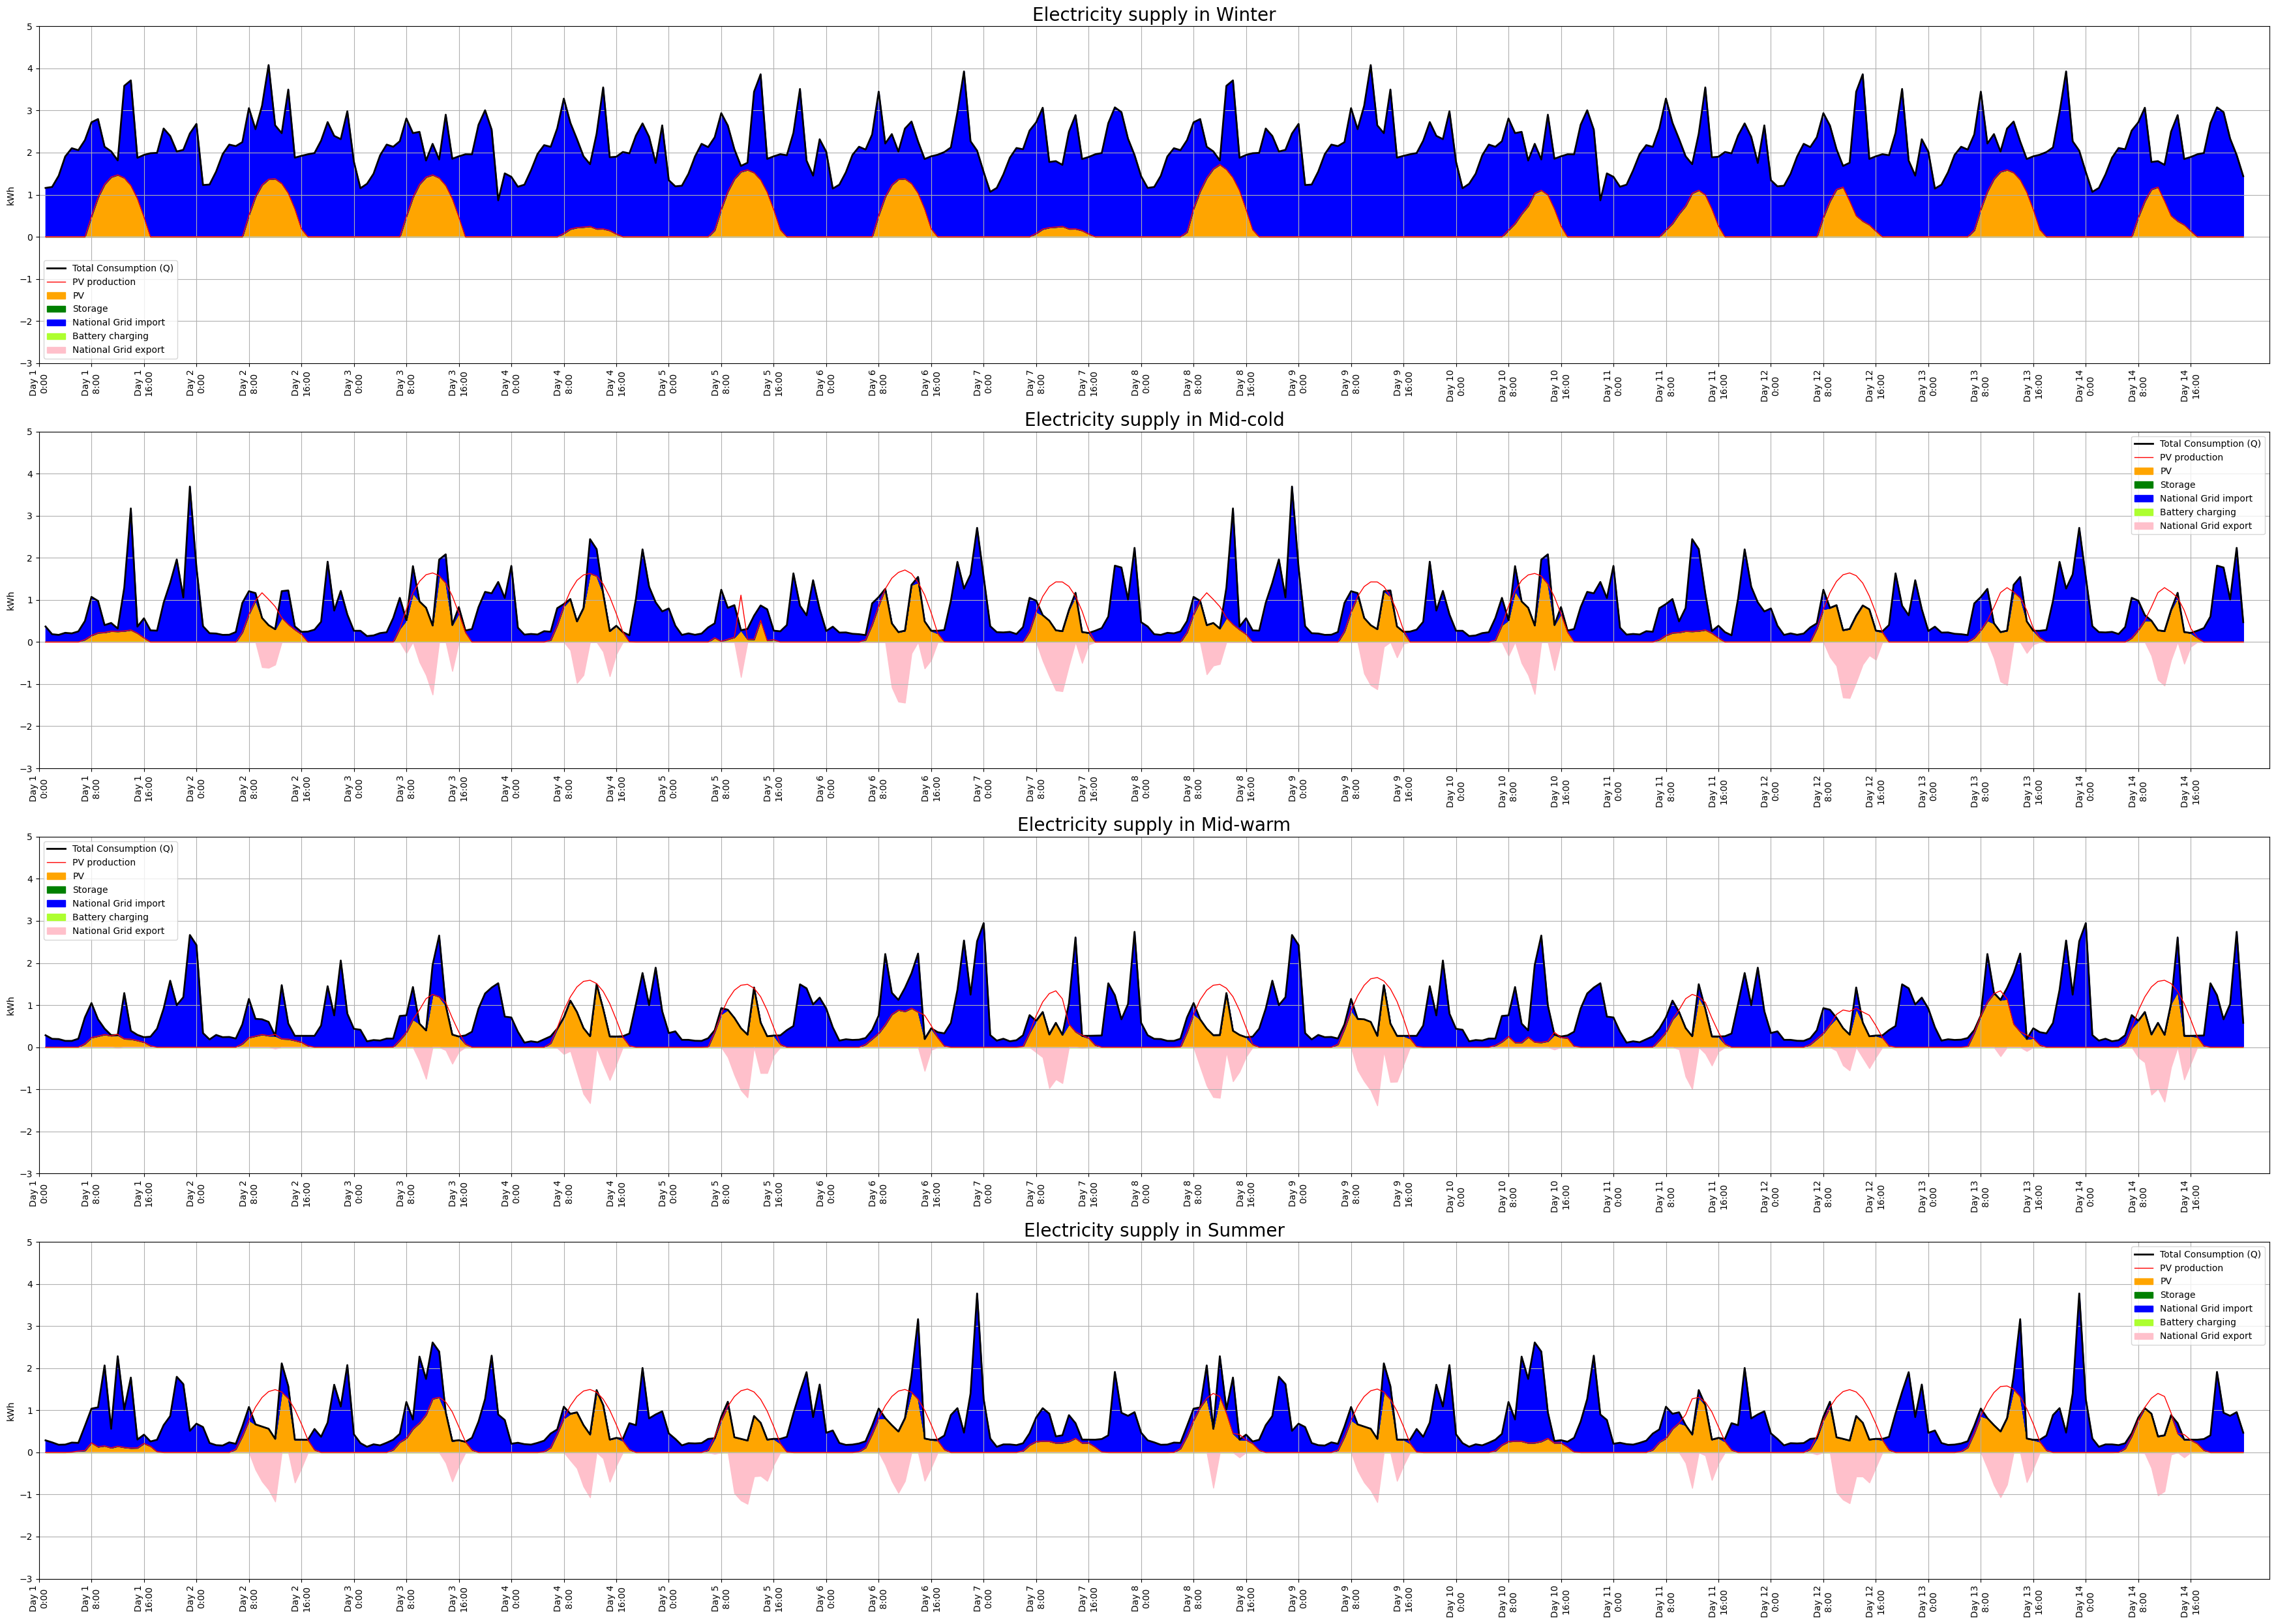

In [91]:
#Electricity production
plt.figure(figsize=(35, 25))
Time=range(1,337)
Time_ind=pd.Index(range(1, 337))
for i, season in enumerate(seasons, 1):
    Q_season = Q[(Q['season'] == season) & (Q['n_names'] == 'EE')]['values']
    PV_prod_season = PV_prod[PV_prod['season'] == season]['values']
    PV_consump_season = PV_consump[PV_consump['season'] == season]['values']
    PV_consump_season.index=Time_ind
    Batt_discharge_season = Batt_discharge[Batt_discharge['season'] == season]['values']
    Batt_discharge_season.index=Time_ind
    EE_grid_season = EE_grid[EE_grid['season'] == season]['values']
    EE_grid_season.index=Time_ind

    Batt_charge_season = Batt_charge[Batt_charge['season'] == season]['values']
    Batt_charge_season.index=Time_ind
    PV_sell_season=-PV_sell[PV_sell['season'] == season]['values']
    PV_sell_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, PV_prod_season, color='red', linewidth=1, label='PV production')
    plt.fill_between(Time,0,PV_consump_season, color='orange', label='PV')
    plt.fill_between(Time,PV_consump_season,PV_consump_season+Batt_discharge_season, color='green', label='Storage')
    plt.fill_between(Time,PV_consump_season+Batt_discharge_season,PV_consump_season+Batt_discharge_season+EE_grid_season, color='blue', label='National Grid import')
    #negative
    plt.fill_between(Time,0,Batt_charge_season, color='greenyellow', label='Battery charging')
    plt.fill_between(Time,Batt_charge_season,Batt_charge_season+PV_sell_season, color='pink', label='National Grid export')
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('kWh')
    plt.ylim(-3,5)
    plt.xlim(0,340)
    plt.title(f'Electricity supply in {season_names[season]}',fontsize=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

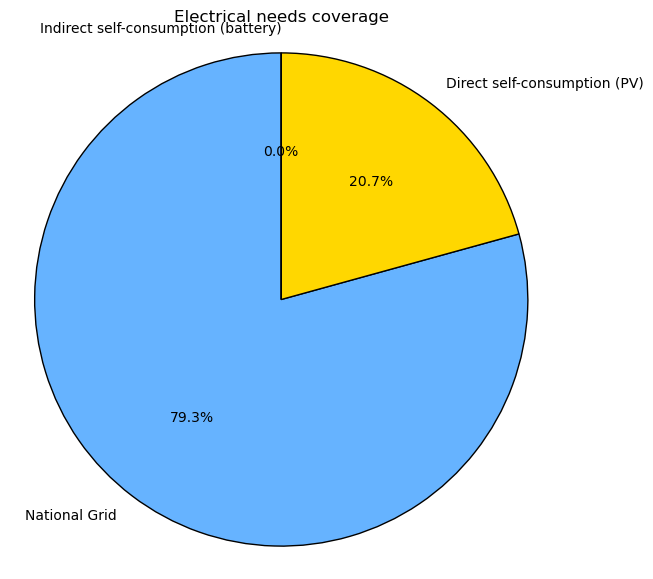

In [92]:
#Coverage of electrical needs
PV_consump_daily=PV_consump.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
PV_consump_daily['consumption'] = PV_consump_daily['consumption']*DPT['values']
import_NG=sum(X_EE_daily['consumption'])
consumo_PV=sum(PV_consump_daily['consumption'])
# Dati ipotetici (puoi modificarli con i tuoi valori)
labels = ['National Grid', 'Direct self-consumption (PV)', 'Indirect self-consumption (battery)']
sizes = [import_NG/Q_EE_tot, consumo_PV/Q_EE_tot,0]# (Q_EE_tot-import_NG-consumo_PV)/Q_EE_tot]  # Percentuali di copertura
colors = ['#66b3ff','gold', '#99ff99']  # Colori personalizzati per ogni categoria

# Creazione del grafico a torta
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})

# Assicurarsi che il grafico sia visualizzato come un cerchio
plt.axis('equal')

# Titolo del grafico
plt.title('Electrical needs coverage')

# Mostra il grafico
plt.show()


Hot water

In [93]:
HP_prod=Xt[Xt['t_names']=='HP']
Boiler_prod=Xt[Xt['t_names']=='Gas Boiler']
HW_storage=X[X['a_names']=='Storing HW']
Q_HW=Q[Q['n_names']=='Hot water']
HP_prod.index = Q_HW.index = Boiler_prod.index=HW_storage.index =range(len(HP_prod))

stor_charge=HW_storage.copy()
stor_charge['values'] = stor_charge['values'].apply(lambda x: 0 if x > 0 else x)
stor_discharge=HW_storage.copy()
stor_discharge['values'] = stor_discharge['values'].apply(lambda x: 0 if x < 0 else x)

HP_use=HP_prod.copy()
HP_use['values']=HP_prod['values'].to_numpy()+stor_charge['values'].to_numpy()

HW_for_heating=Q[Q['n_names']=='Heat']
HW_for_heating['values']=HW_for_heating['values']*1.2

/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_53992/3051566527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HW_for_heating['values']=HW_for_heating['values']*1.2


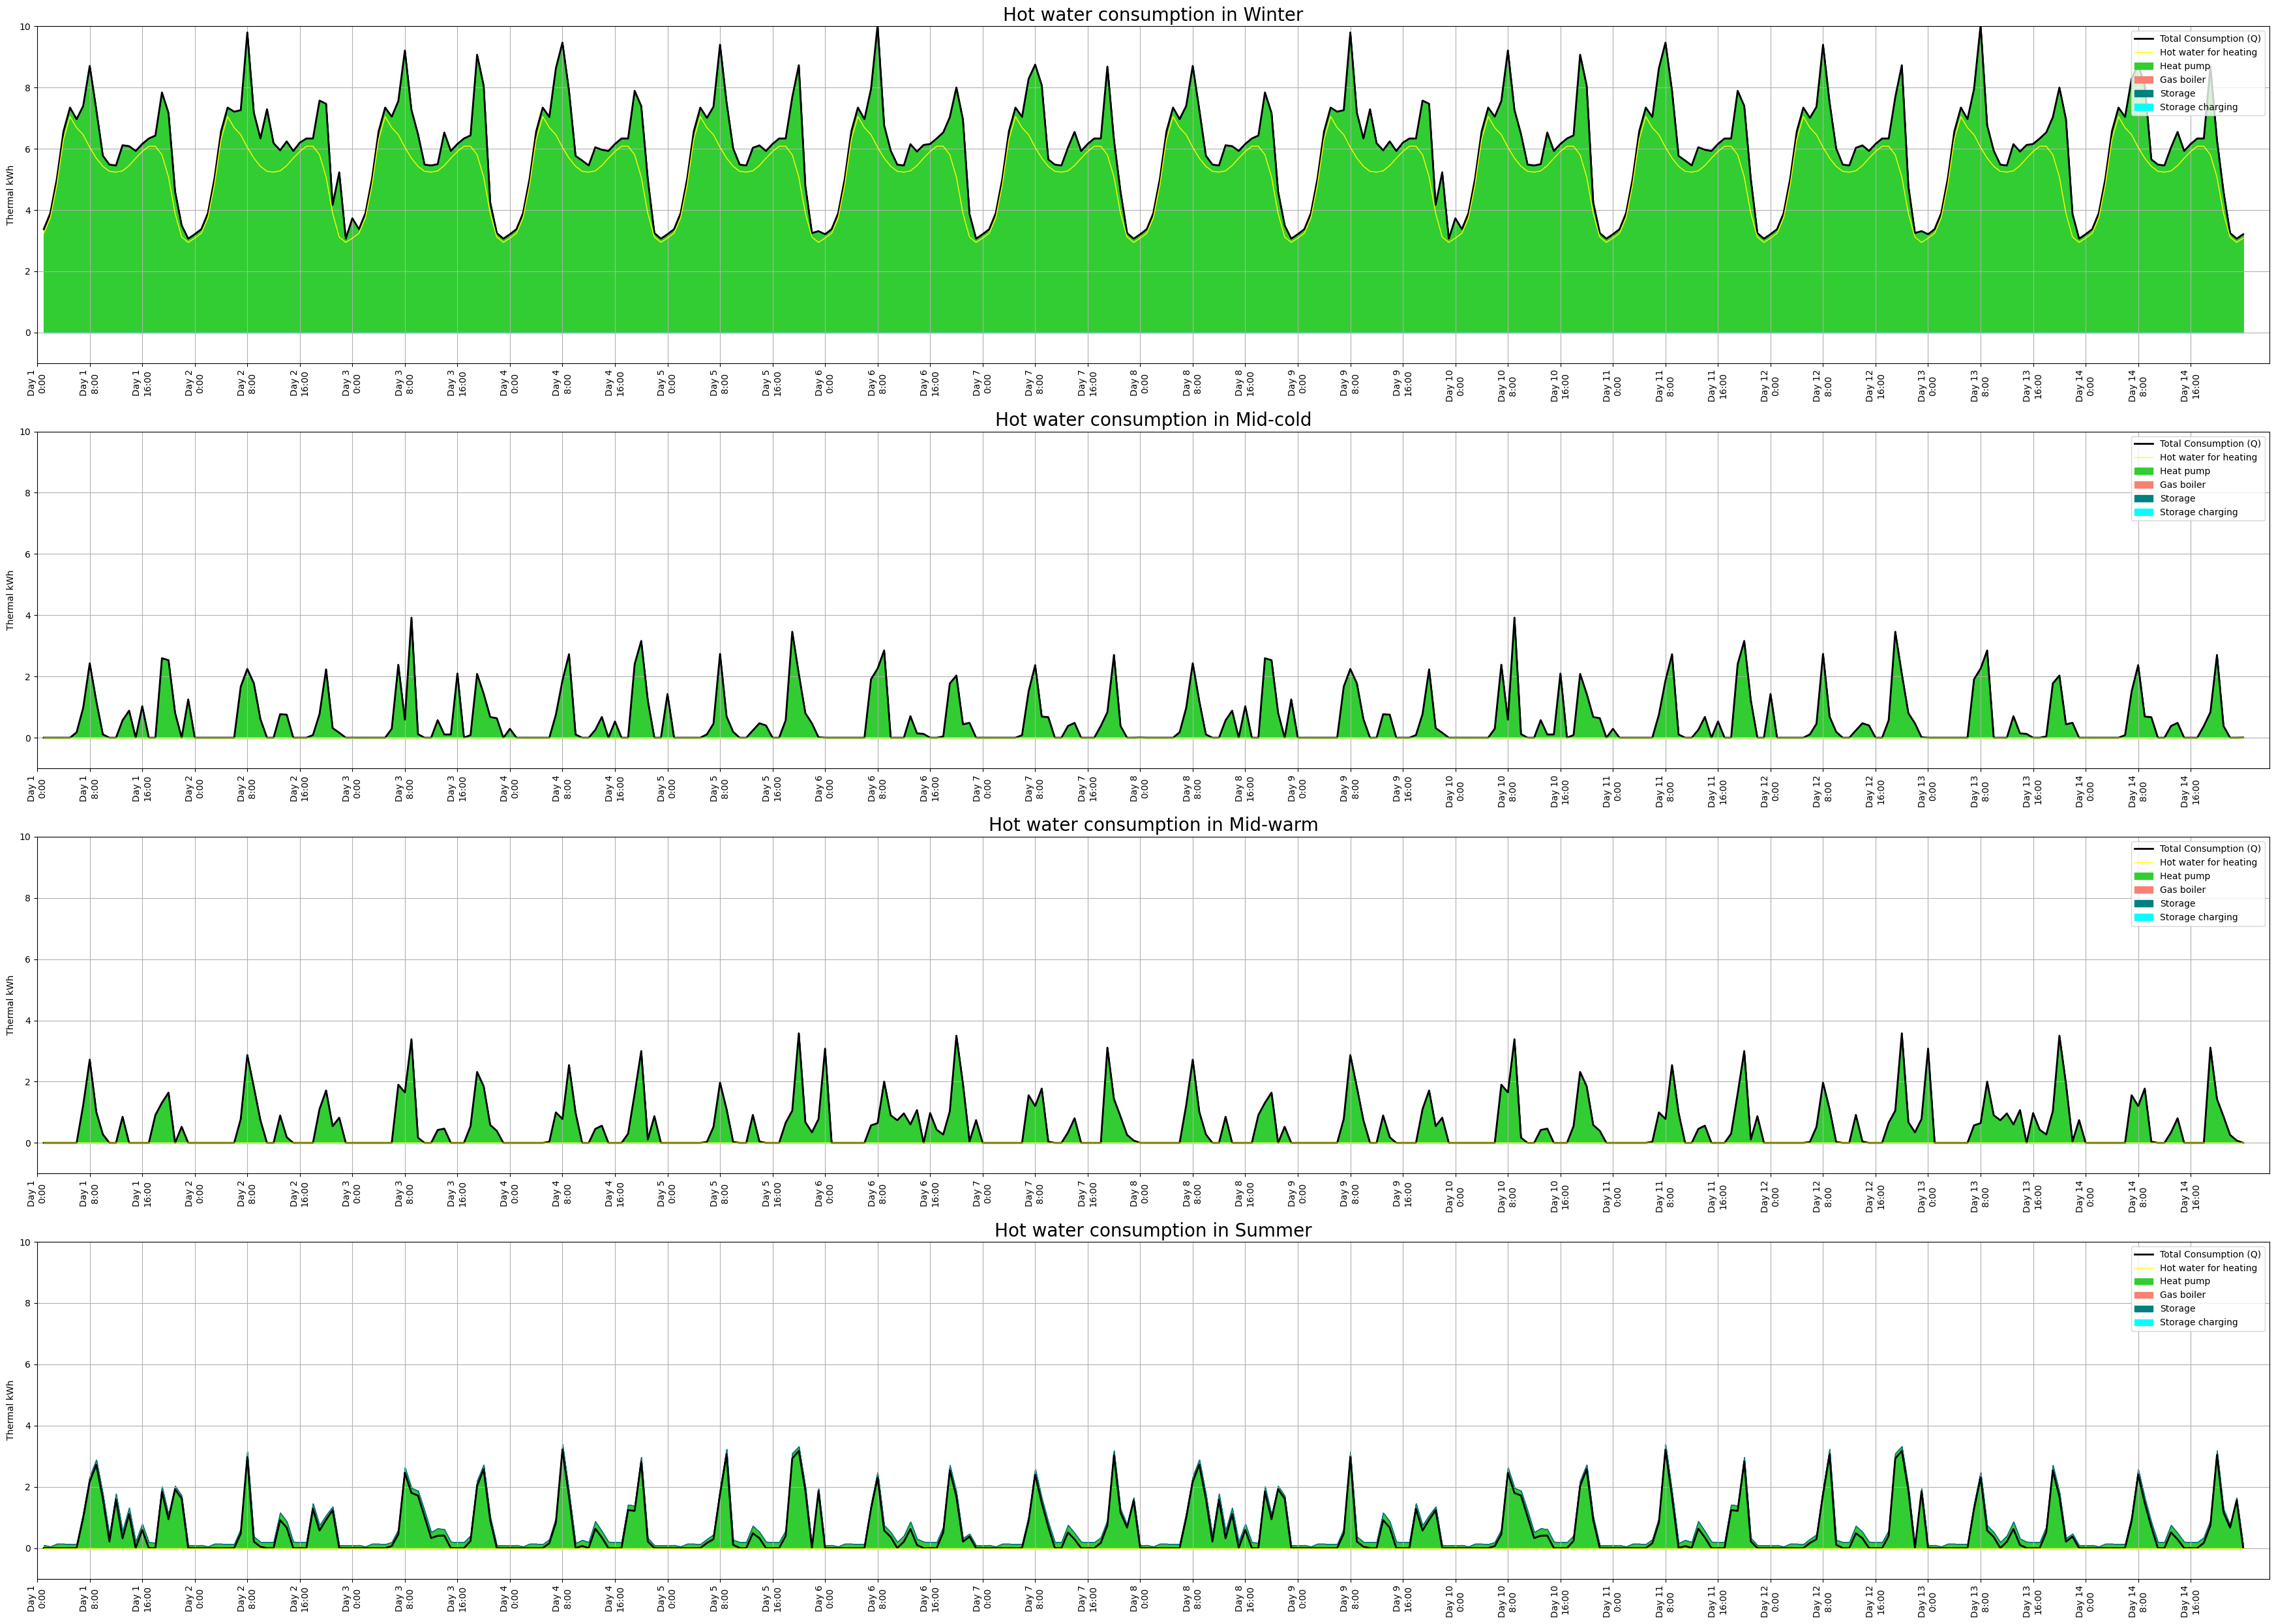

In [94]:
#Hot water production
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    Q_HW_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Hot water')]['values']
    HP_use_season = HP_use[HP_use['season'] == season]['values']
    Boiler_prod_season = Boiler_prod[Boiler_prod['season'] == season]['values']
    stor_charge_season = stor_charge[stor_charge['season'] == season]['values']
    #PV_consump_season.index=Time_ind
    stor_discharge_season = stor_discharge[stor_discharge['season'] == season]['values']
    HW_heating_season = HW_for_heating[HW_for_heating['season'] == season]['values']

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_HW_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, HW_heating_season, color='yellow', linewidth=1, label='Hot water for heating')
    plt.fill_between(Time,0,HP_use_season, color='limegreen', label='Heat pump')
    plt.fill_between(Time,HP_use_season,HP_use_season+Boiler_prod_season, color='salmon', label='Gas boiler')
    plt.fill_between(Time,HP_use_season+Boiler_prod_season,HP_use_season+Boiler_prod_season+stor_discharge_season, color='teal', label='Storage')
    #negative
    plt.fill_between(Time,0,stor_charge_season, color='cyan', label='Storage charging')
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('Thermal kWh')
    plt.ylim(-1,10)
    plt.xlim(0,340)
    plt.title(f'Hot water consumption in {season_names[season]}',fontsize=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

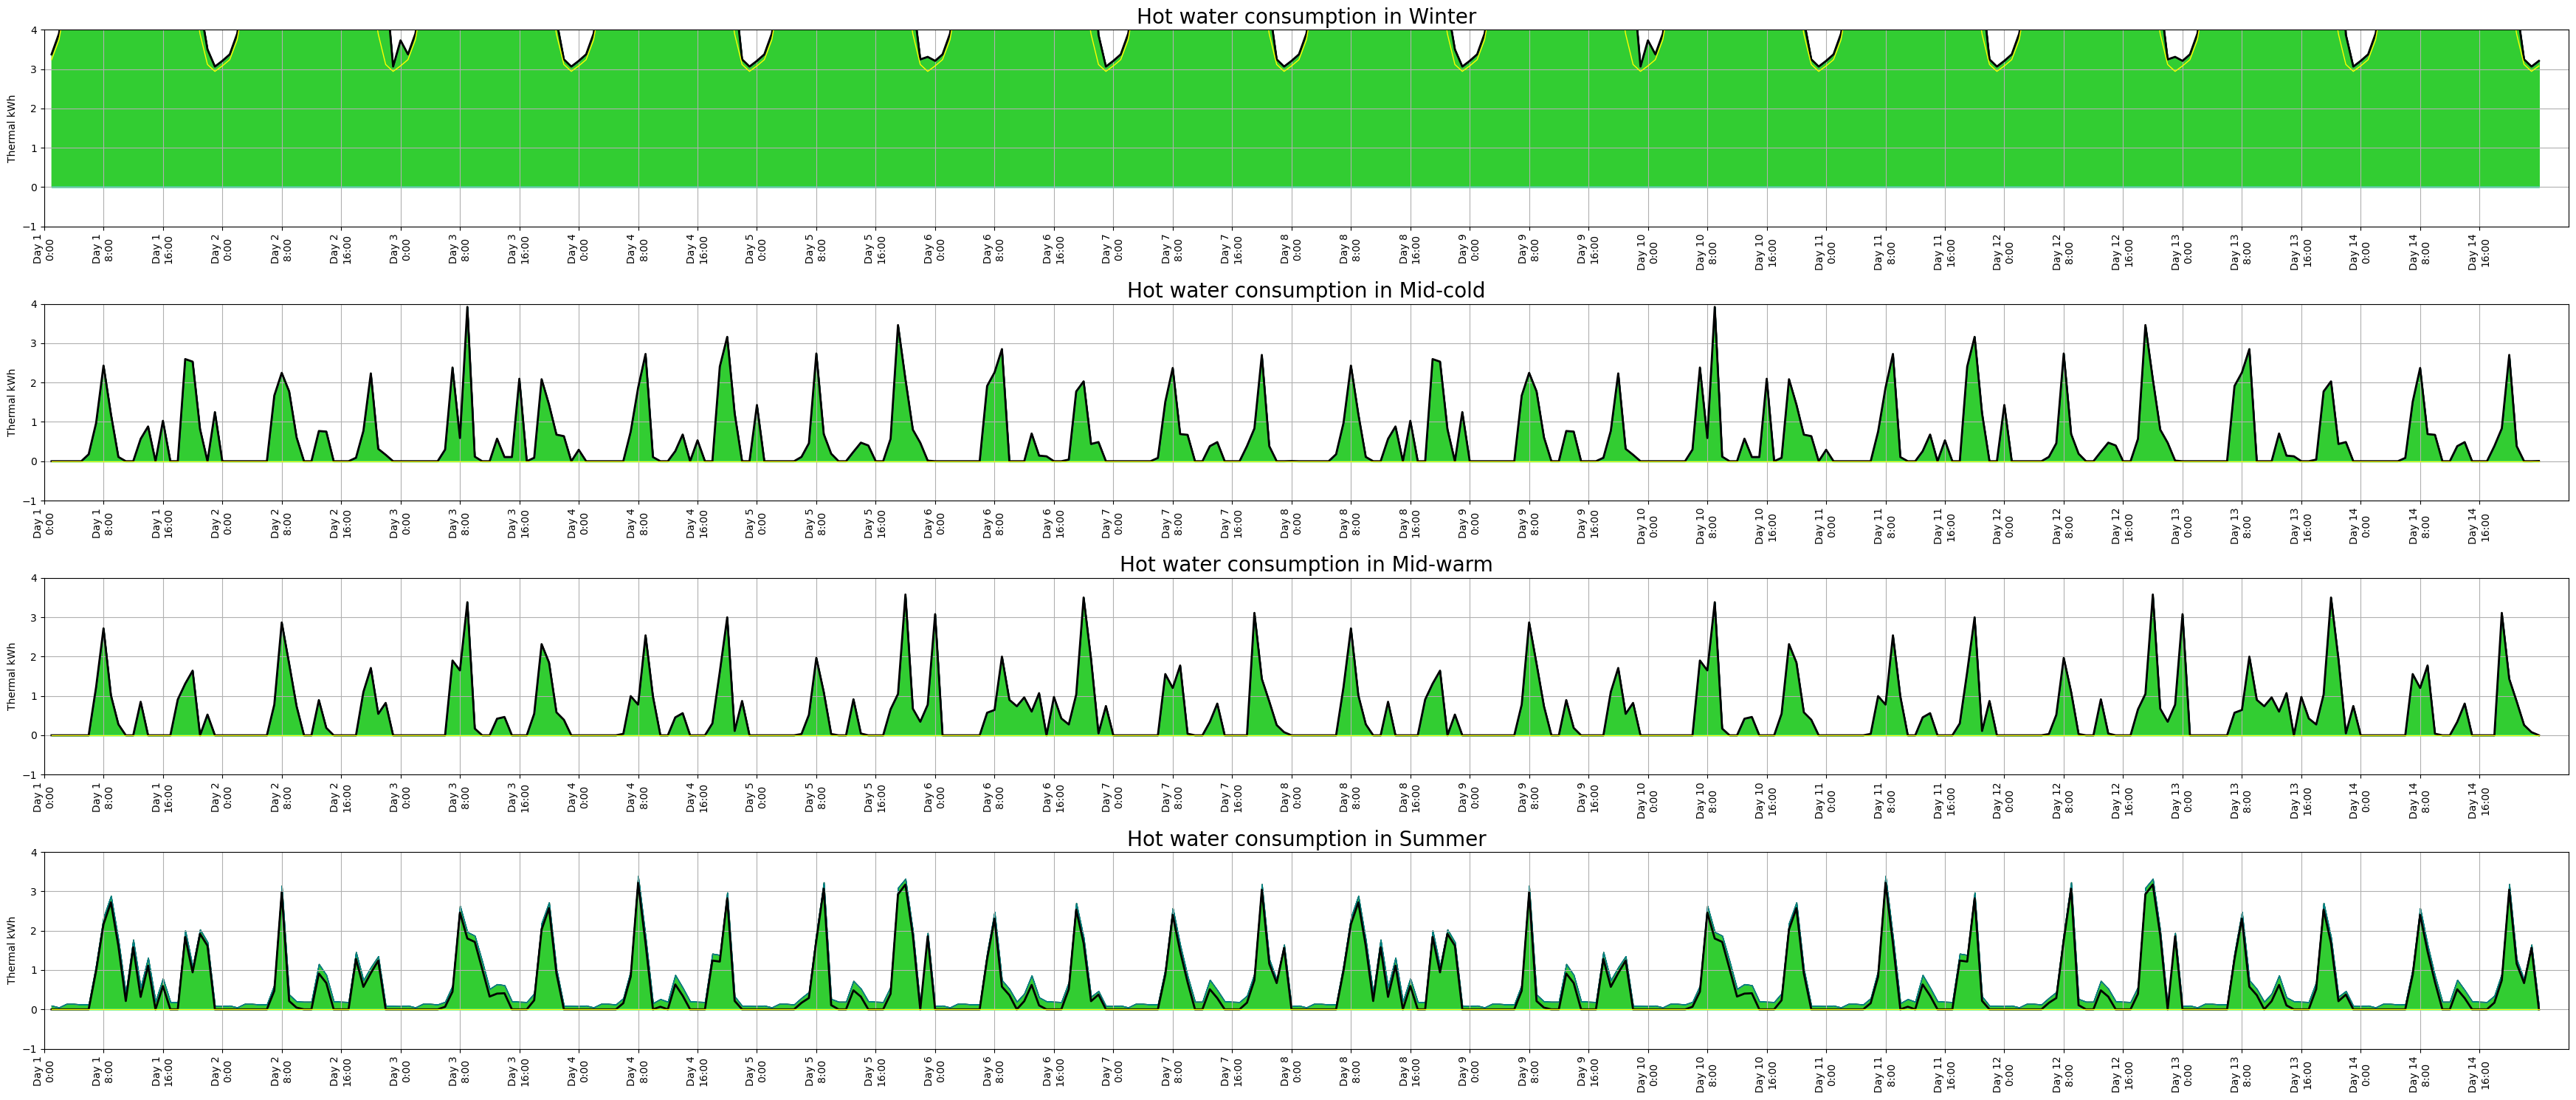

In [95]:
#Zoom hot water production
plt.figure(figsize=(35, 15))

for i, season in enumerate(seasons, 1):
    Q_HW_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Hot water')]['values']
    HP_use_season = HP_use[HP_use['season'] == season]['values']
    Boiler_prod_season = Boiler_prod[Boiler_prod['season'] == season]['values']
    stor_charge_season = stor_charge[stor_charge['season'] == season]['values']
    #PV_consump_season.index=Time_ind
    stor_discharge_season = stor_discharge[stor_discharge['season'] == season]['values']
    HW_heating_season = HW_for_heating[HW_for_heating['season'] == season]['values']

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_HW_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, HW_heating_season, color='yellow', linewidth=1, label='Hot water for heating')
    plt.fill_between(Time,0,HP_use_season, color='limegreen', label='Heat pump')
    plt.fill_between(Time,HP_use_season,HP_use_season+Boiler_prod_season, color='salmon', label='Gas boiler')
    plt.fill_between(Time,HP_use_season+Boiler_prod_season,HP_use_season+Boiler_prod_season+stor_discharge_season, color='teal', label='Storage')
    #negative
    plt.fill_between(Time,0,stor_charge_season, color='cyan', label='Storage charging')
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('Thermal kWh')
    plt.ylim(-1,4)
    plt.xlim(0,340)
    plt.title(f'Hot water consumption in {season_names[season]}',fontsize=20)
    plt.grid(True)

plt.tight_layout()
plt.show()

Heating?

Cooking

In [96]:
Gas_stove=X[X['a_names']=='Gas stove cooking']
Ind_stove=X[X['a_names']=='Induction stove cooking']
Gas_stove.index = Ind_stove.index =range(len(Gas_stove))

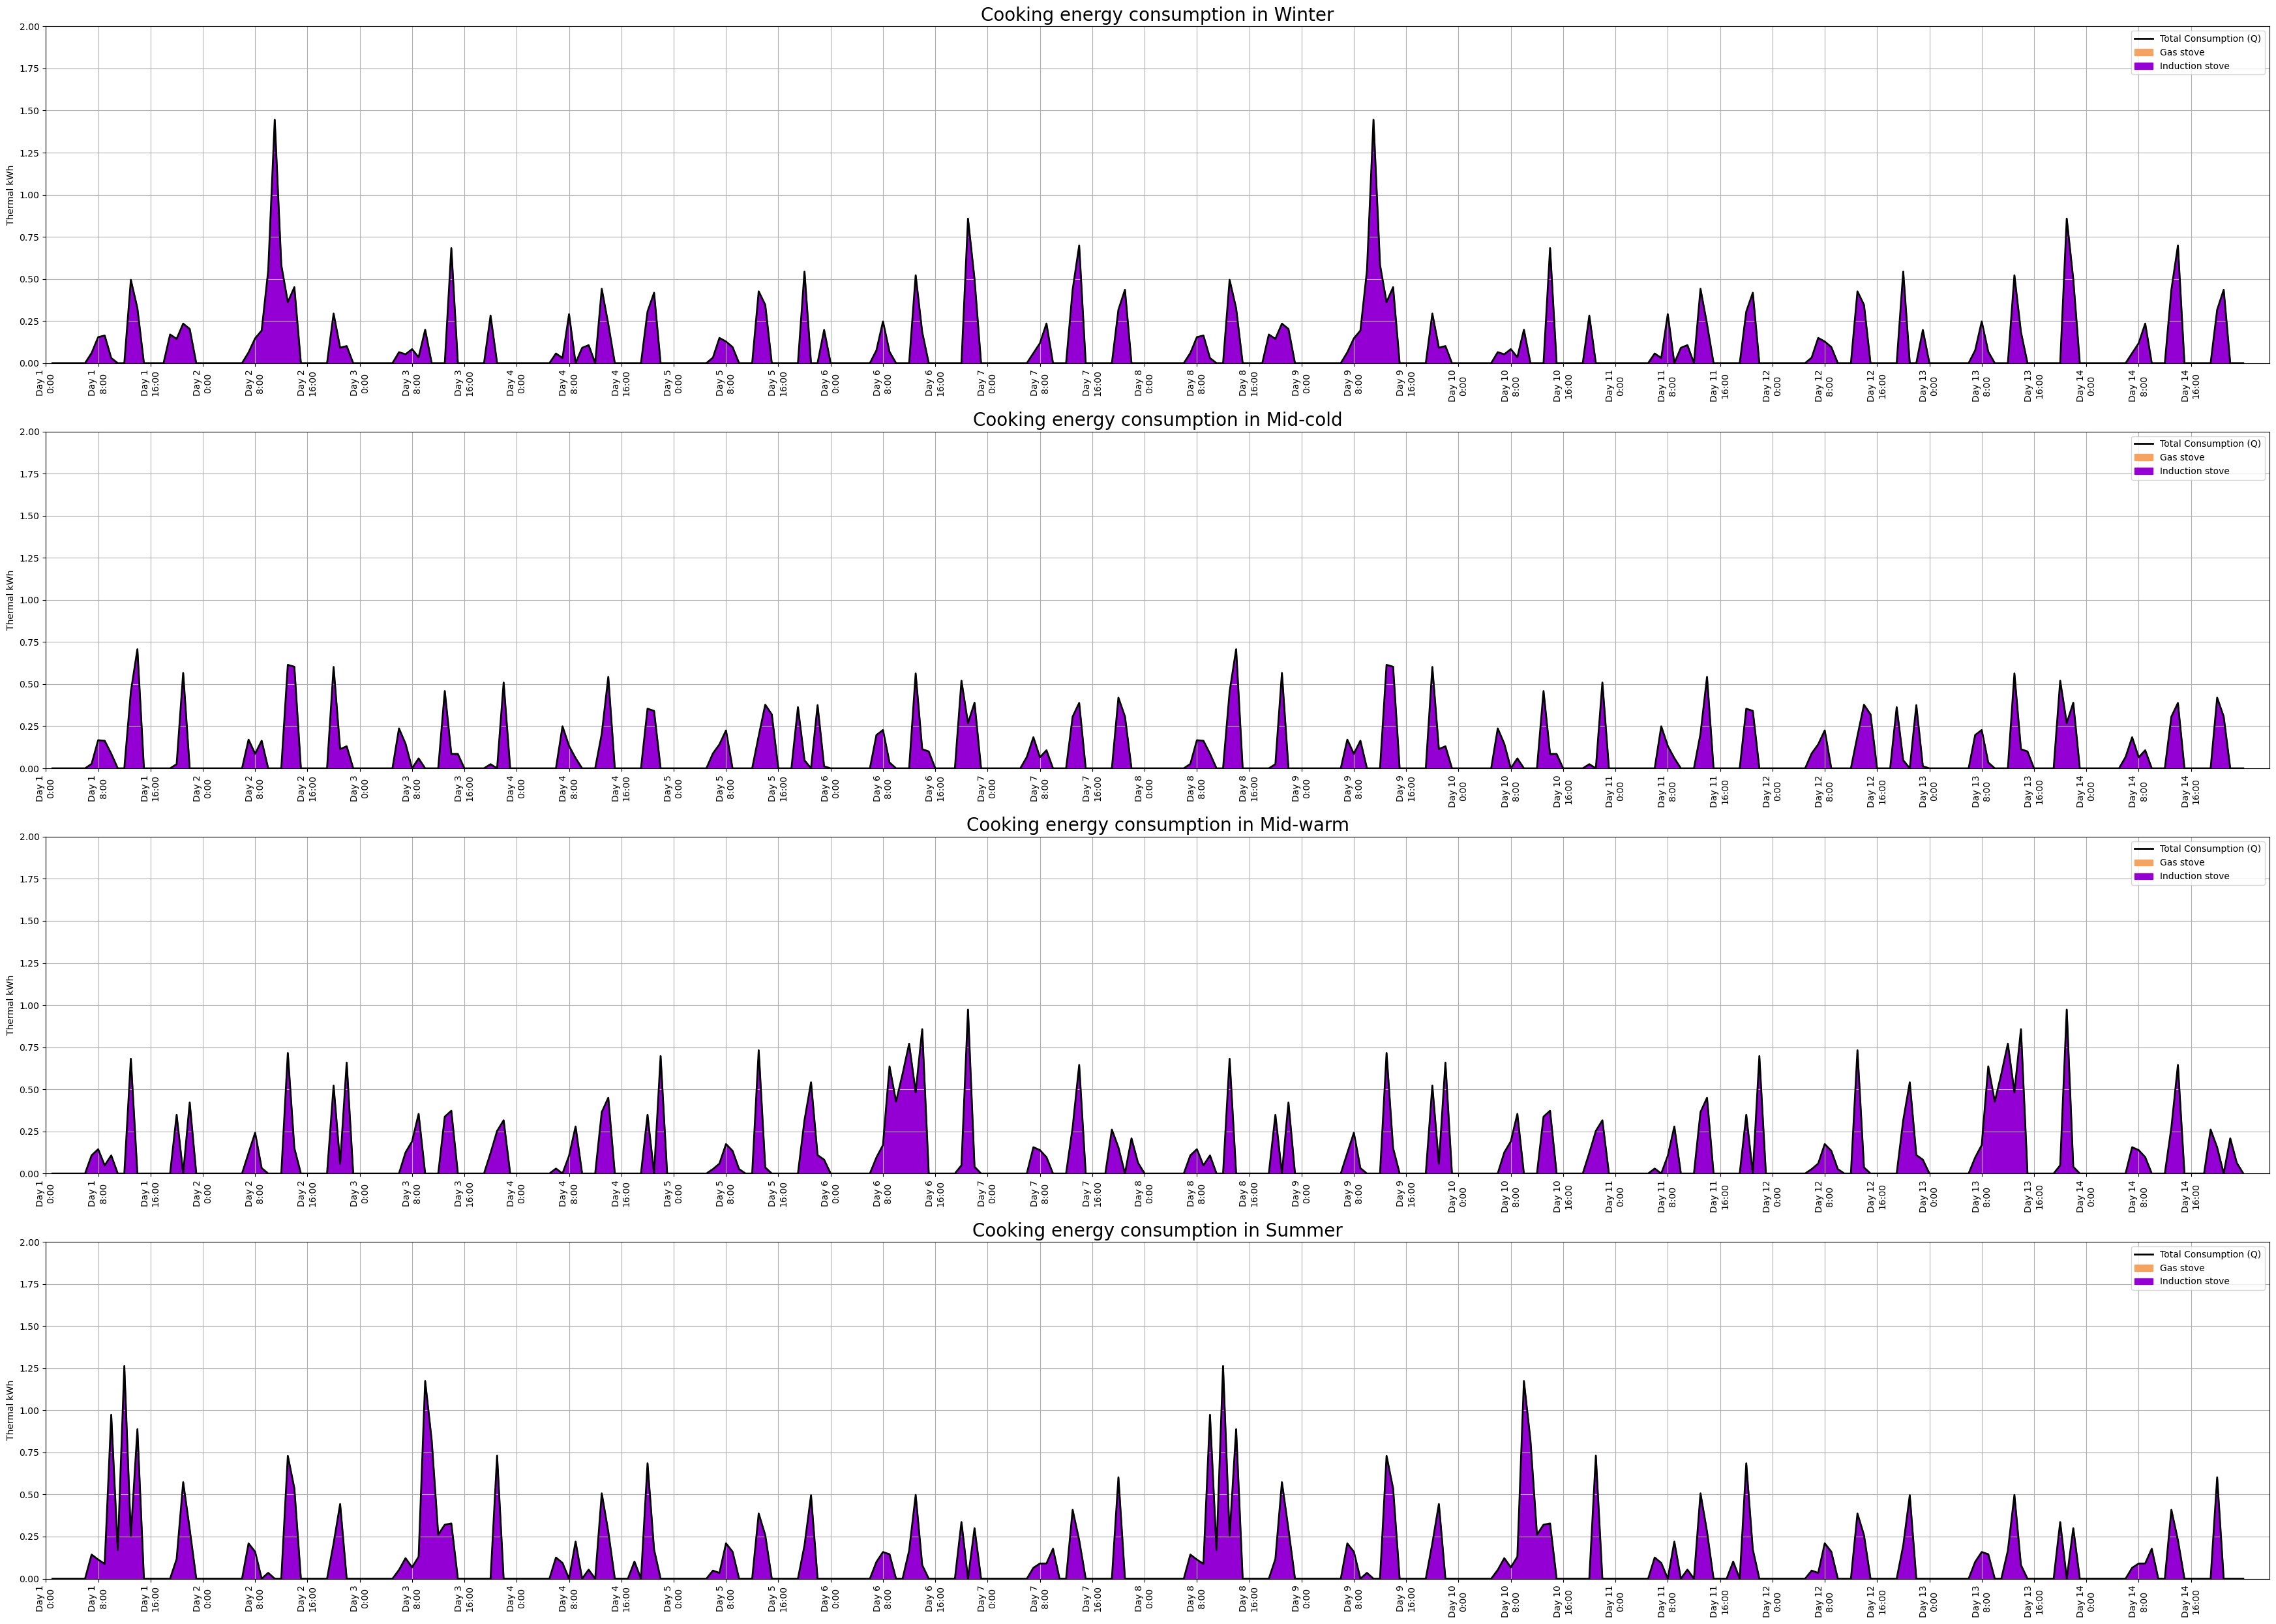

In [97]:
#Cooking consumption
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    Q_cook_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Cooking')]['values']
    Gas_stove_season = Gas_stove[Gas_stove['season'] == season]['values']
    Ind_stove_season = Ind_stove[Ind_stove['season'] == season]['values']
    #PV_consump_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_cook_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.fill_between(Time,0,Gas_stove_season, color='sandybrown', label='Gas stove')
    plt.fill_between(Time,0,Ind_stove_season, color='darkviolet', label='Induction stove')
    #negative
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('Thermal kWh')
    plt.ylim(0,2)
    plt.xlim(0,340)
    plt.title(f'Cooking energy consumption in {season_names[season]}',fontsize=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Natural Gas

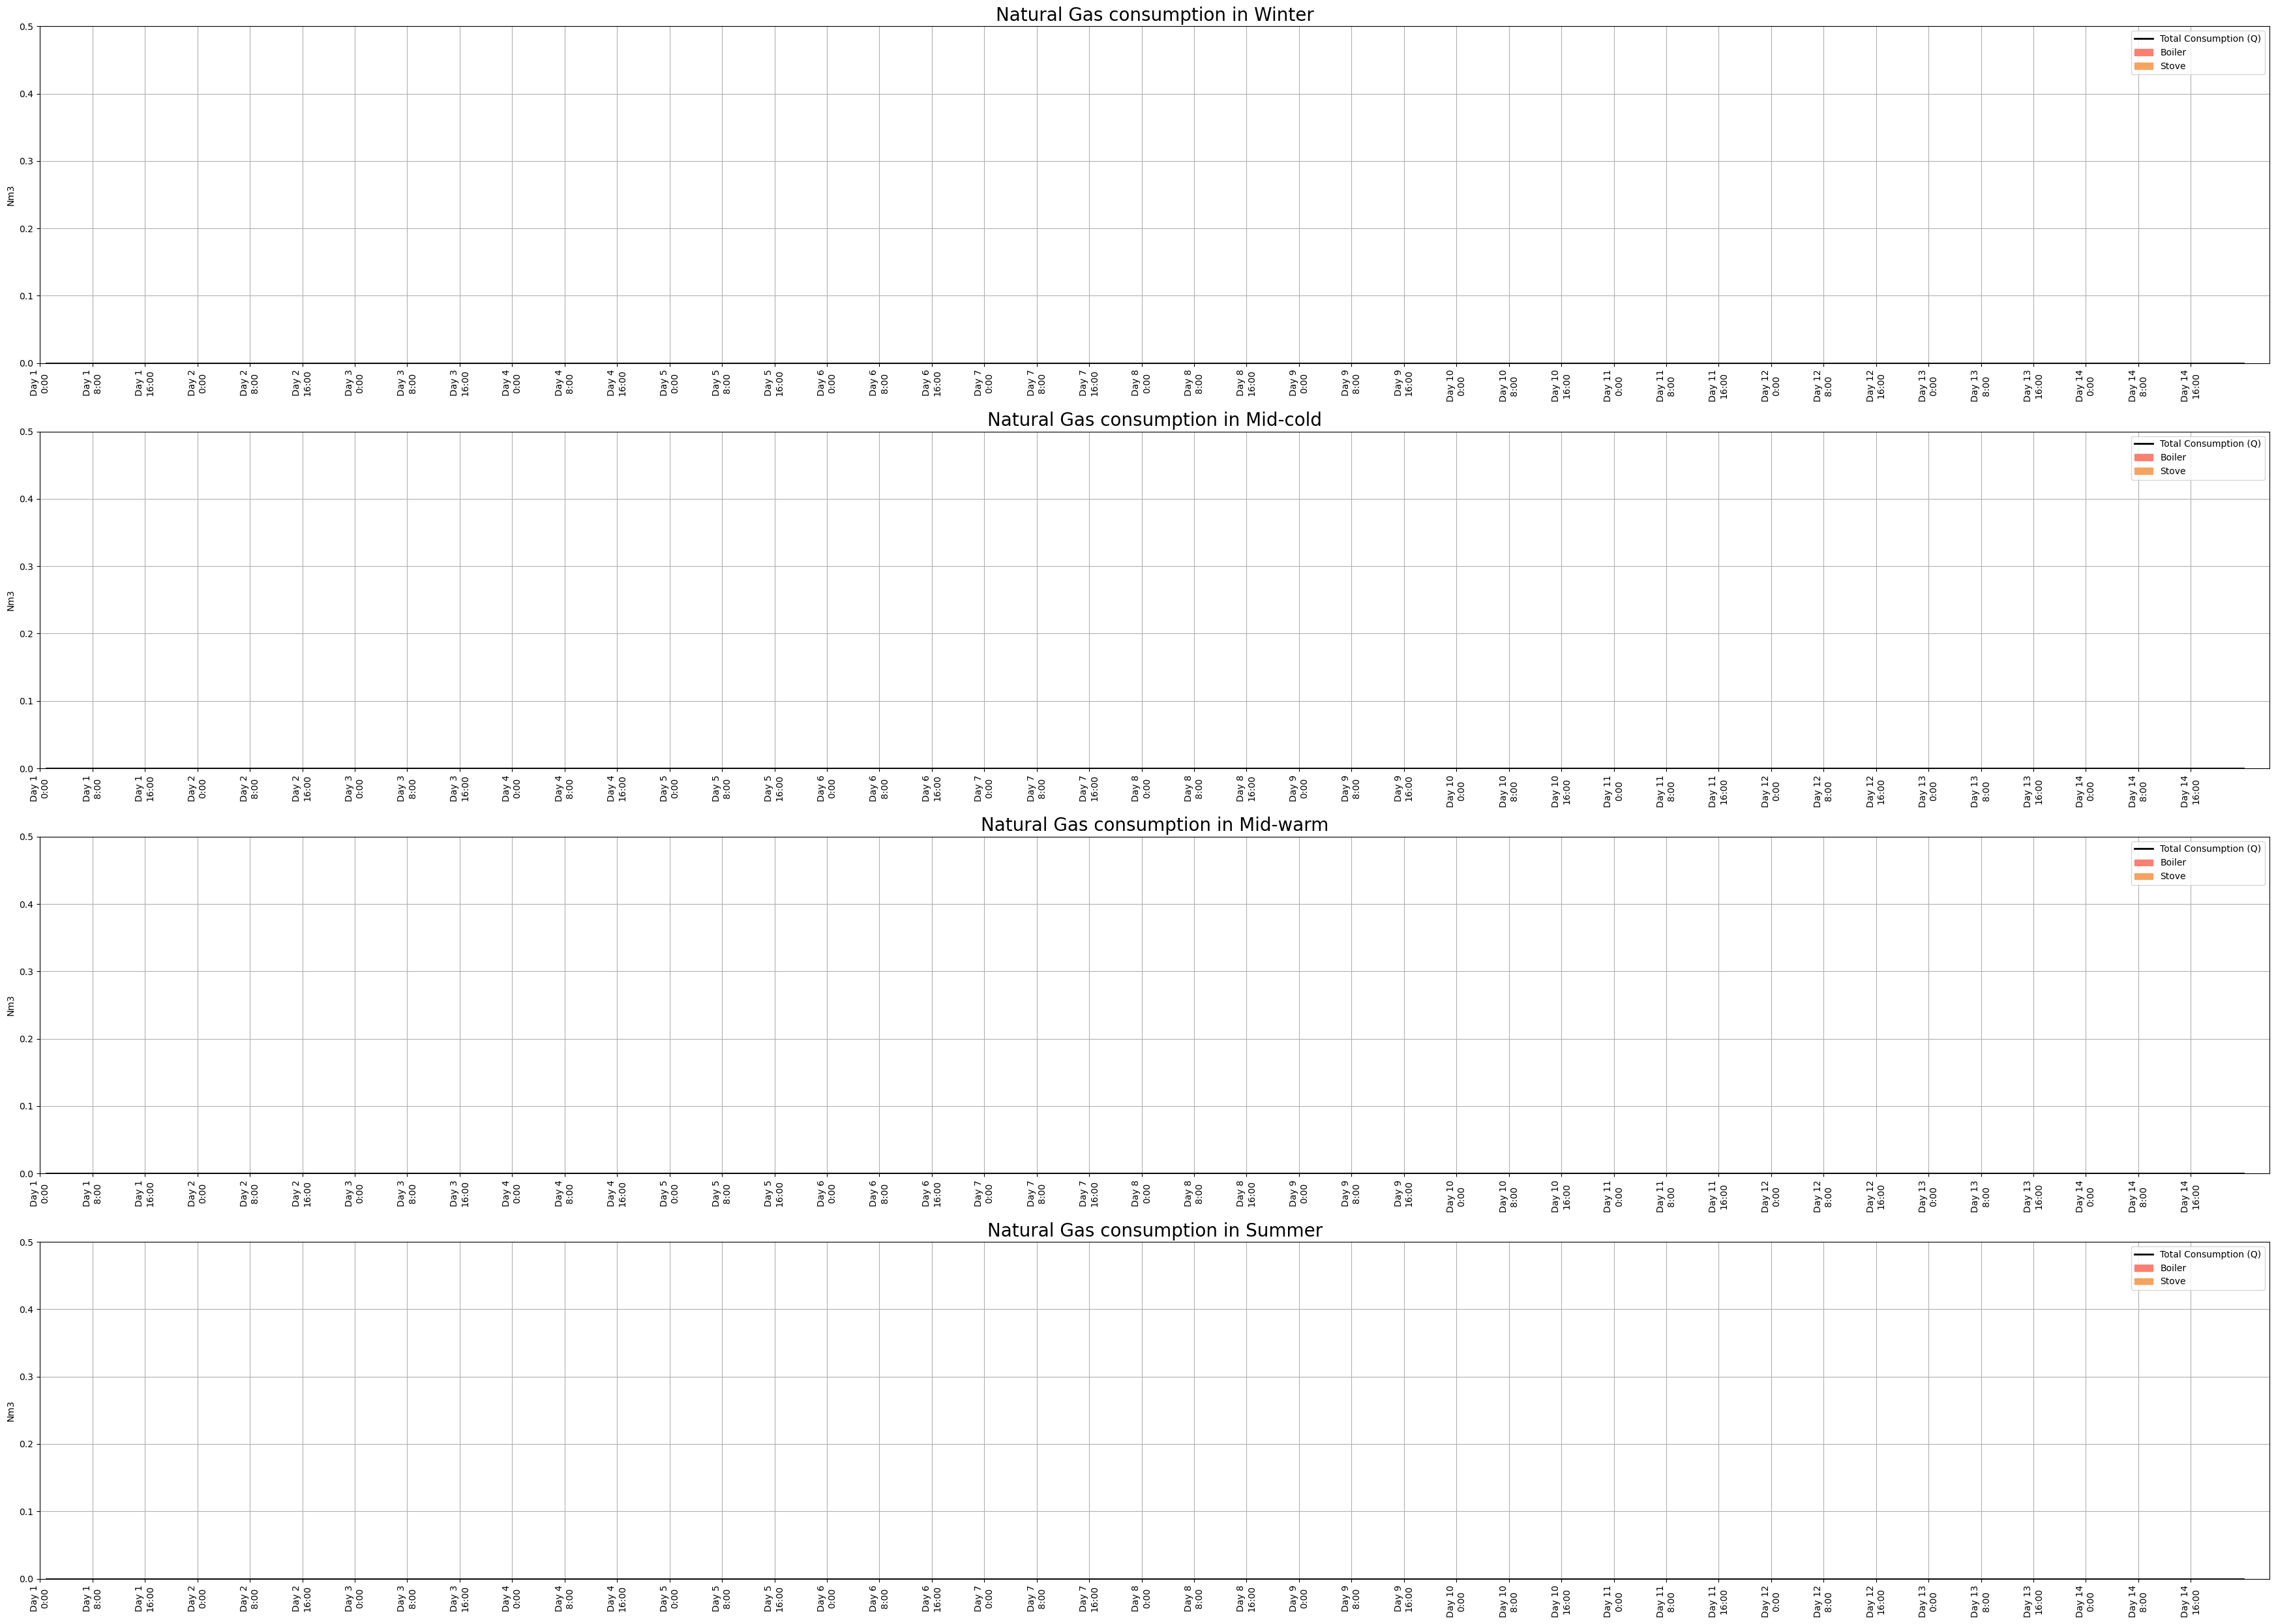

In [98]:
#Natural gas consumption
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    Q_gas_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Natural Gas')]['values']
    Boiler_prod_season = Boiler_prod[Boiler_prod['season'] == season]['values']/10.94/0.95
    Gas_stove_season = Gas_stove[Gas_stove['season'] == season]['values']/10.94/0.4

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_gas_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.fill_between(Time,0,Boiler_prod_season, color='salmon', label='Boiler')
    plt.fill_between(Time,Boiler_prod_season,Boiler_prod_season+Gas_stove_season, color='sandybrown', label='Stove')
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('Nm3')
    plt.ylim(0,0.5)
    plt.xlim(0,340)
    plt.title(f'Natural Gas consumption in {season_names[season]}',fontsize=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

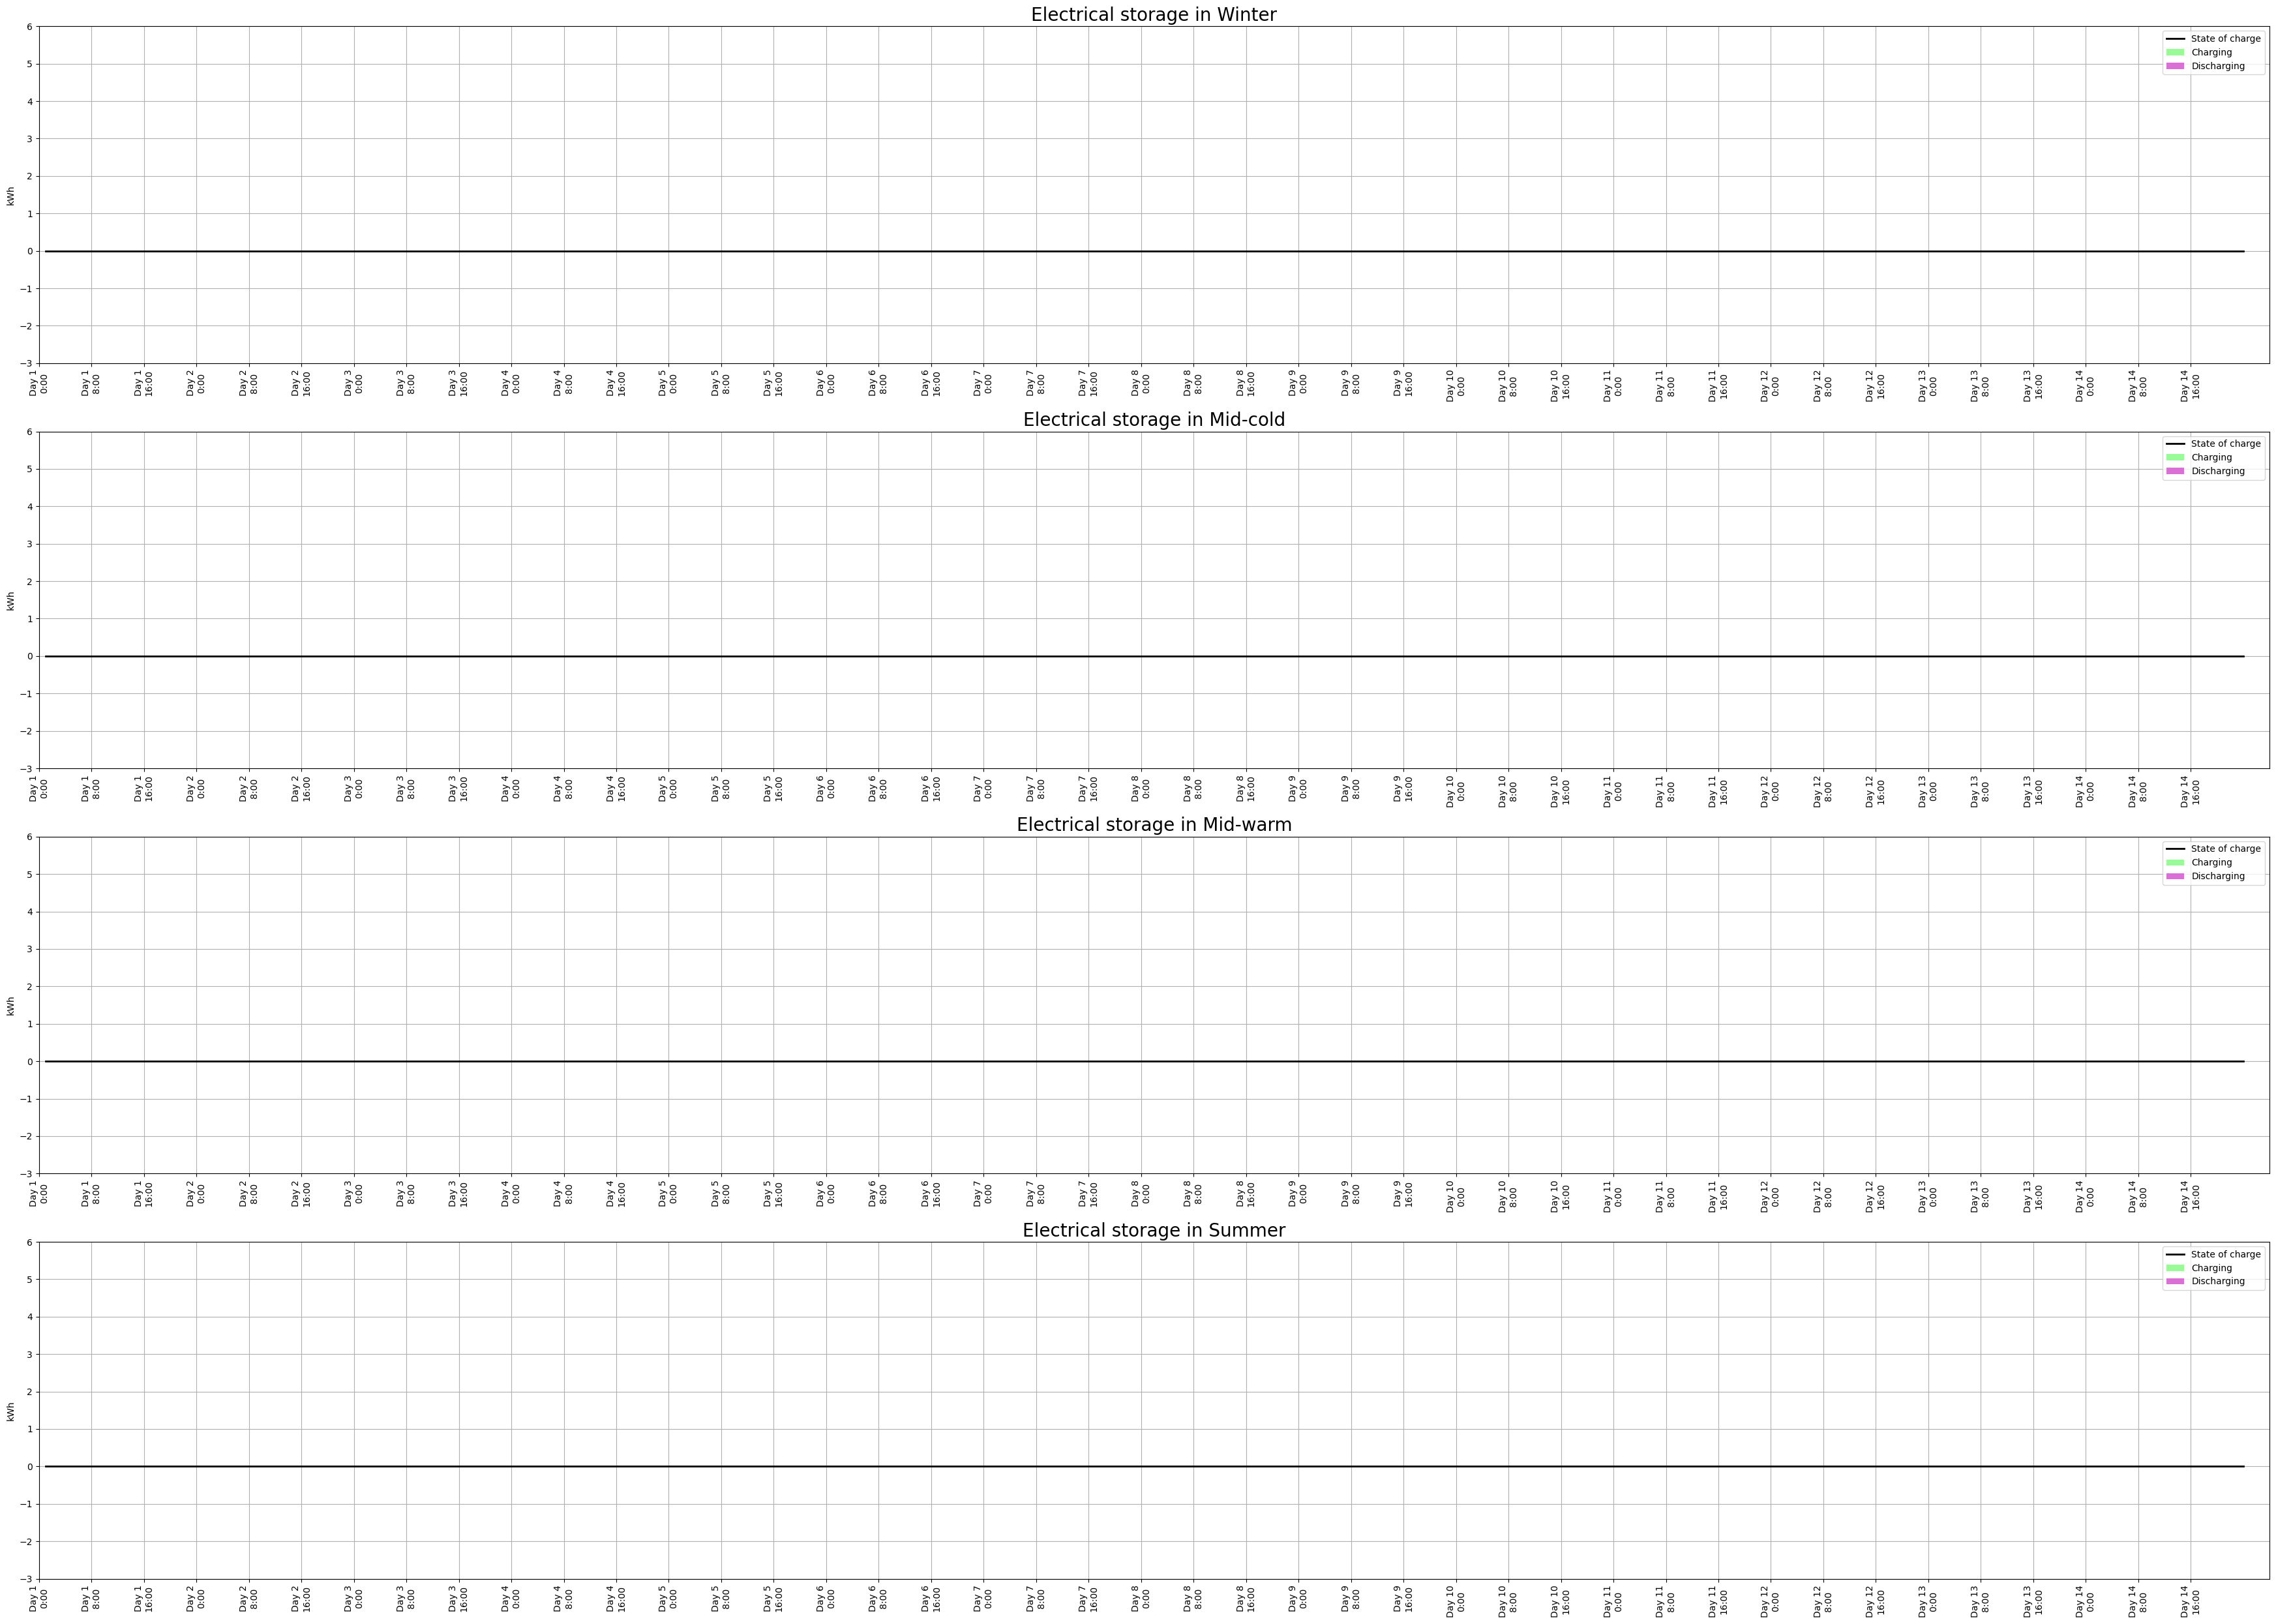

In [99]:
#EE storage SOC
SOCEE=SOC[SOC['t_names']=='Storage EE']
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    Batt_charge_season = -Batt_charge[Batt_charge['season'] == season]['values']
    Batt_discharge_season = -Batt_discharge[Batt_discharge['season'] == season]['values']
    SOCEE_season = SOCEE[SOCEE['season'] == season]['values']
    #PV_consump_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, SOCEE_season, color='black', linewidth=2, label='State of charge')
    plt.bar(Time,Batt_charge_season, color='palegreen', label='Charging')
    plt.bar(Time,Batt_discharge_season,color='orchid', label='Discharging')
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('kWh')
    plt.ylim(-3,6)
    plt.xlim(0,340)
    plt.title(f'Electrical storage in {season_names[season]}',fontsize=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

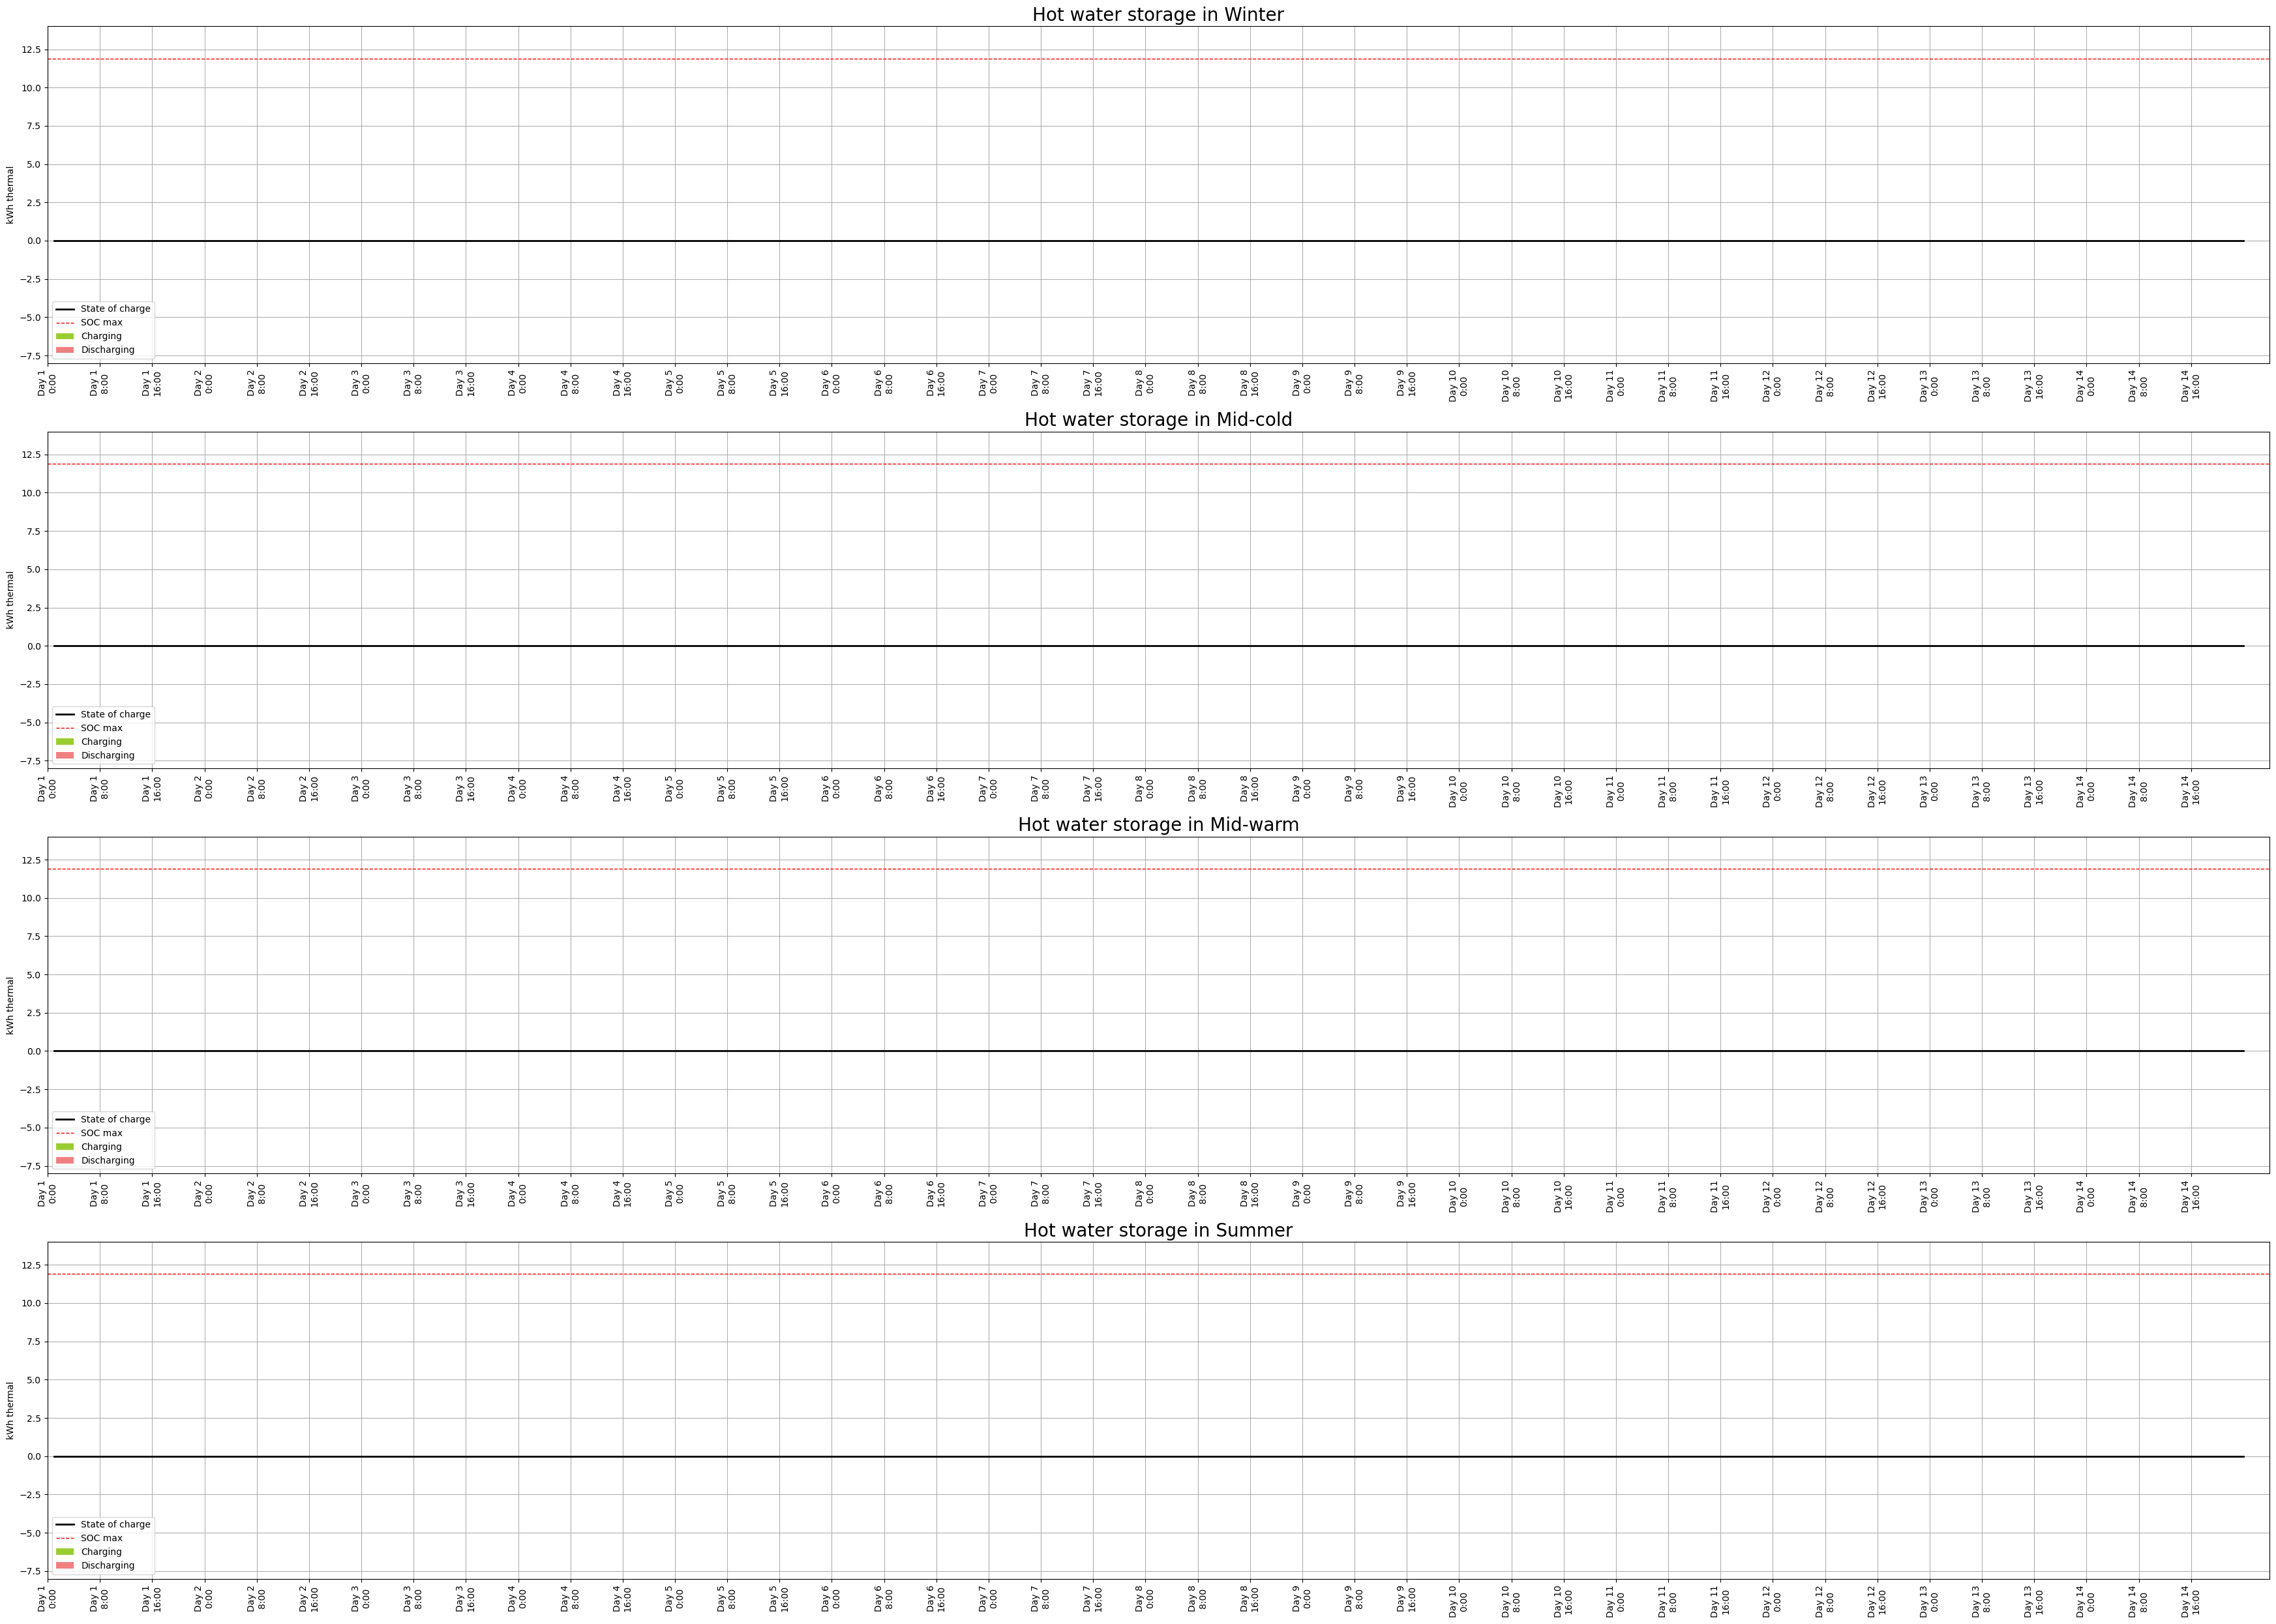

In [100]:
#HW storage SOC
SOCHW=SOC[SOC['t_names']=='Storage HW']
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    stor_charge_season = -stor_charge[Batt_charge['season'] == season]['values']
    stor_discharge_season = -stor_discharge[stor_discharge['season'] == season]['values']
    SOCHW_season = SOCHW[SOCHW['season'] == season]['values']
    #PV_consump_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, SOCHW_season, color='black', linewidth=2, label='State of charge')
    plt.bar(Time,stor_charge_season, color='yellowgreen', label='Charging')
    plt.bar(Time,stor_discharge_season,color='lightcoral', label='Discharging')
    plt.axhline(y=11.9, color='red', linestyle='--', linewidth=1, label='SOC max')
    plt.xticks(ticks=np.arange(0, 336, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('kWh thermal')
    plt.ylim(-8,14)
    plt.xlim(0,340)
    plt.title(f'Hot water storage in {season_names[season]}',fontsize=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()